In [189]:
# load analytics.csv in dataframe
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# load the csv file
df = pd.read_csv('analytics.csv')

In [190]:
# Create a new data frame, where it only includes a single sample of each type of event. The event is the "type" column.
df_unique = df.drop_duplicates(subset=["type"])
df_unique


,id,type,url,payload,user_id,session_id,received_at,created_at,domain
0,19500,from-directs,www.lessextension.com/,"""anticonsumption""",less-website,none,2025-03-27T01:06:50.771229+00:00,2025-03-27T01:06:50.072+00:00,lessextension.com
5,19505,page-view,foto.foetex.dk/billeder.html,NaN,390c0190-33a3-4029-ae09-687bff0b77d6,71a85cb4-a94d-4c74-9410-bc04dea00ba5,2025-03-27T07:23:39.255773+00:00,2025-03-27T07:23:38.148+00:00,foetex.dk
6,19506,time-spent,foto.foetex.dk/billeder.html,"{""duration"":5009}",390c0190-33a3-4029-ae09-687bff0b77d6,71a85cb4-a94d-4c74-9410-bc04dea00ba5,2025-03-27T07:23:43.734083+00:00,2025-03-27T07:23:43.128+00:00,foetex.dk
19,19519,on-onboarding,www.lessextension.com/onboarding,"""""",none,none,2025-03-27T07:24:55.70906+00:00,2025-03-27T07:24:56.412+00:00,lessextension.com
47,19547,checkout,foto.foetex.dk/checkout.html,NaN,390c0190-33a3-4029-ae09-687bff0b77d6,71a85cb4-a94d-4c74-9410-bc04dea00ba5,2025-03-27T07:48:53.399341+00:00,2025-03-27T07:48:52.814+00:00,foetex.dk
143,19642,welcome-modal-seen,www.ticketmaster.dk/event/555879,NaN,0b7cd927-52ef-434b-8b2e-9c63281c6327,3804850e-e2b7-4bc7-bd7b-88bd88f7a7a0,2025-03-27T15:27:14.463082+00:00,2025-03-27T15:27:13.93+00:00,ticketmaster.dk
203,19701,from-directs-cta,www.lessextension.com/,"""shoppingaddiction""",less-website,none,2025-03-27T21:32:22.421951+00:00,2025-03-27T21:32:22.176+00:00,lessextension.com
224,19722,uninstall,www.lessextension.com/goodbye,NaN,1e42348b-77f0-4eb2-911b-93e0e27bd8a0,27c7dad0-c441-4134-84c8-7b436b5cac86,2025-03-29T16:14:40.952129+00:00,2025-03-29T16:14:36.678+00:00,lessextension.com
281,19779,open-popup,kcgblchgejkpnemehaojecgbamdiacml/popup.html,NaN,5c7c5d5f-ad28-401e-b6f0-6d6f167cc726,912d2198-750b-4b63-ab02-5ccaf4eff500,2025-03-31T09:32:24.938499+00:00,2025-03-31T09:32:24.233+00:00,kcgblchgejkpnemehaojecgbamdiacml
459,19971,add-to-cart,www.amazon.com/gp/product/1108724264/ref=as_li_tl,NaN,a584c10c-d236-408a-b544-50b6219dee39,ec7e6bf4-b2ee-4d06-869d-69c5b8a71c1a,2025-04-02T12:11:11.798597+00:00,2025-04-02T12:11:11.089+00:00,amazon.com


In [191]:
# count different types of events
event_counts = df["type"].value_counts()
print(event_counts)

type
time-spent                            11905
page-view                              1195
from-directs                            220
on-onboarding                           181
checkout                                 54
add-to-cart                              54
from-directs-cta                         44
uninstall                                33
open-popup                               31
enforce_wait_modal_shown                 27
active                                   19
welcome-modal-seen                       18
questionary-popup                        15
enforce_wait_canceled                    12
enforce_wait_info_expanded               10
questionary-closed                        7
open-options                              4
enforce_wait_permit_valid_on_click        4
place-order                               2
questionary-finished                      2
Name: count, dtype: int64


In [192]:
import re

# Count unique user IDs
# Define a regex pattern for UUIDv4
uuidv4_pattern = re.compile(r'^[a-f0-9]{8}-[a-f0-9]{4}-4[a-f0-9]{3}-[89ab][a-f0-9]{3}-[a-f0-9]{12}$', re.IGNORECASE)

# Filter user_id's that match the UUIDv4 pattern
uuidv4 = df[df["user_id"].apply(lambda x: bool(uuidv4_pattern.match(x)))]
unique_users = uuidv4["user_id"].nunique()

uninstalled = df[df["type"] == "uninstall"]
unique_uninstalled = uninstalled["user_id"].nunique()
unique_installed = unique_users - unique_uninstalled

# look at the last active event for each unique user. If the last event has a payload of "false", this means they've deactivated it.
# I'd like to know how many of the current installed users have deactivated the extension.
last_active = df[df["type"] == "active"]
last_active = last_active.drop_duplicates(subset=["user_id"], keep="last")
last_active = last_active[last_active["payload"] == "false"]
deactivated_but_not_uninstalled = len(last_active[~last_active["user_id"].isin(uninstalled["user_id"].values)])
totally_active = unique_installed - deactivated_but_not_uninstalled
on_onboarding = df[(df["type"] == "on-onboarding") & (df["payload"].apply(lambda x: x != '""'))]

print("Installations:", len(on_onboarding), "\nUser activity seen from", unique_users, "\nuninstalled:", unique_uninstalled, "\ndeactivated:", deactivated_but_not_uninstalled, "\nTotal registered active users:", totally_active)


Installations: 8 
User activity seen from 61 
uninstalled: 33 
deactivated: 4 
Total registered active users: 24


In [193]:
# group by session_id
# remove any rows that have a null session_id.
df_only_with_session = df[df["session_id"] != "none"]


In [194]:
# 1. Filter out all events that do not have sessions (already done above)
print(f"Total rows in dataset: {len(df)}")
print(f"Rows with valid session_id: {len(df_only_with_session)}")
print(f"Percentage of events with session: {len(df_only_with_session) / len(df) * 100:.2f}%")

"""
# Create a pie chart of session event counts
plt.figure(figsize=(10, 7))
event_counts_categories = pd.cut(events_per_session, 
                                 bins=[0, 1, 2, 3, 4, np.inf], 
                                 labels=['1', '2', '3', '4', '5+'])
event_counts_distribution = event_counts_categories.value_counts().sort_index()
plt.pie(event_counts_distribution, 
        labels=event_counts_distribution.index,
        autopct='%1.1f%%', 
        startangle=90)
plt.title('Distribution of Events per Session')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show() """

# 2. Count the number of unique sessions
unique_sessions = df_only_with_session["session_id"].nunique()
print(f"\nTotal number of unique sessions: {unique_sessions}")

# Convert created_at to datetime
# Convert created_at to datetime, handling mixed formats
df_only_with_session['created_at'] = pd.to_datetime(df_only_with_session['created_at'], format='mixed', errors='coerce')

# Group by session_id and find first and last event timestamps
session_lengths = df_only_with_session.groupby('session_id').agg({
    'created_at': ['min', 'max']
})

# Flatten the multi-index columns
session_lengths.columns = ['start_time', 'end_time']

# Calculate session duration in seconds
session_lengths['duration_seconds'] = (session_lengths['end_time'] - session_lengths['start_time']).dt.total_seconds()
session_lengths['duration_minutes'] = session_lengths['duration_seconds'] / 60

# Count sessions with zero length
zero_length_sessions = (session_lengths['duration_seconds'] == 0).sum()
print(f"\nNumber of zero-length sessions: {zero_length_sessions}")
print(f"Percentage of zero-length sessions: {zero_length_sessions/len(session_lengths)*100:.2f}%")

# Count very short sessions (less than 1 second)
very_short_sessions = (session_lengths['duration_seconds'] < 1).sum()
print(f"\nNumber of very short sessions (< 1 second): {very_short_sessions}")
print(f"Percentage of very short sessions: {very_short_sessions/len(session_lengths)*100:.2f}%")

# Create a distribution of session durations
session_duration_ranges = [
    (0, 'Zero seconds'),
    (1, '< 1 second'),
    (5, '1-5 seconds'),
    (10, '5-10 seconds'),
    (30, '10-30 seconds'),
    (60, '30-60 seconds'),
    (300, '1-5 minutes'),
    (600, '5-10 minutes'),
    (1800, '10-30 minutes'),
    (float('inf'), '> 30 minutes')
]

# Create bins for the distribution
session_bins = {}
prev_threshold = 0
for threshold, label in session_duration_ranges:
    count = ((session_lengths['duration_seconds'] >= prev_threshold) & 
             (session_lengths['duration_seconds'] < threshold)).sum()
    session_bins[label] = count
    prev_threshold = threshold

# Print the distribution
print("\nSession length distribution:")
for label, count in session_bins.items():
    print(f"{label}: {count} sessions ({count/len(session_lengths)*100:.2f}%)")

# Calculate average session length
avg_session_length_minutes = session_lengths['duration_minutes'].mean()
median_session_length_minutes = session_lengths['duration_minutes'].median()
print(f"\nAverage session length: {avg_session_length_minutes:.2f} minutes")
print(f"Median session length: {median_session_length_minutes:.2f} minutes")

# Count events per session
events_per_session = df_only_with_session.groupby('session_id').size()
avg_events_per_session = events_per_session.mean()
print(f"\nAverage events per session: {avg_events_per_session:.2f}")

Total rows in dataset: 13837
Rows with valid session_id: 13392
Percentage of events with session: 96.78%

Total number of unique sessions: 227

Number of zero-length sessions: 48
Percentage of zero-length sessions: 21.15%

Number of very short sessions (< 1 second): 53
Percentage of very short sessions: 23.35%

Session length distribution:
Zero seconds: 0 sessions (0.00%)
< 1 second: 53 sessions (23.35%)
1-5 seconds: 11 sessions (4.85%)
5-10 seconds: 9 sessions (3.96%)
10-30 seconds: 19 sessions (8.37%)
30-60 seconds: 19 sessions (8.37%)
1-5 minutes: 49 sessions (21.59%)
5-10 minutes: 17 sessions (7.49%)
10-30 minutes: 36 sessions (15.86%)
> 30 minutes: 14 sessions (6.17%)

Average session length: 8.94 minutes
Median session length: 1.23 minutes

Average events per session: 59.00


/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_68723/3754191441.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_with_session['created_at'] = pd.to_datetime(df_only_with_session['created_at'], format='mixed', errors='coerce')


/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_68723/2777736887.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_session_lengths = session_lengths[(1/6) <= session_lengths['duration_minutes']][session_lengths['duration_minutes'] <= 30]


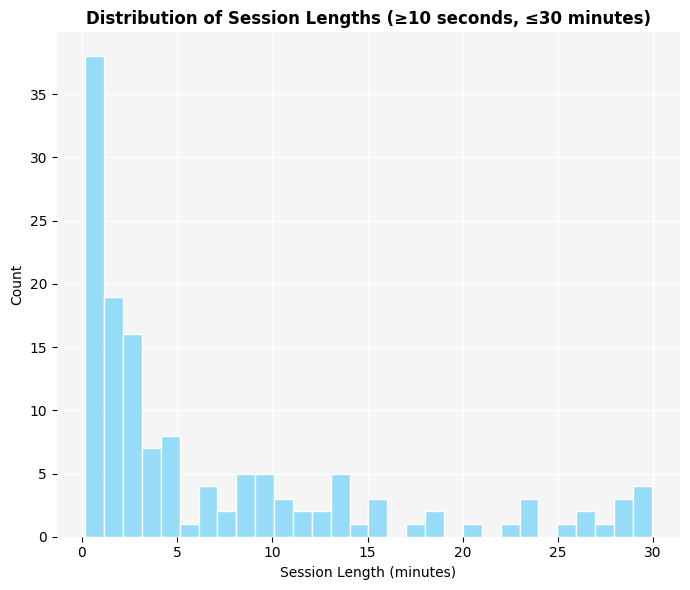

In [195]:
plt.figure(figsize=(7, 6))
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D',  '#106ED3']

ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

filtered_session_lengths = session_lengths[(1/6) <= session_lengths['duration_minutes']][session_lengths['duration_minutes'] <= 30]
sns.histplot(filtered_session_lengths['duration_minutes'], color='#6ED1F8', edgecolor='white', bins=30, alpha=0.7, zorder=2)
plt.title('Distribution of Session Lengths (≥10 seconds, ≤30 minutes)', fontweight='bold')
plt.xlabel('Session Length (minutes)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('plots/session_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_68723/2336183194.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_session_lengths = session_lengths[(1/6) <= session_lengths['duration_minutes']][session_lengths['duration_minutes'] <= 10]


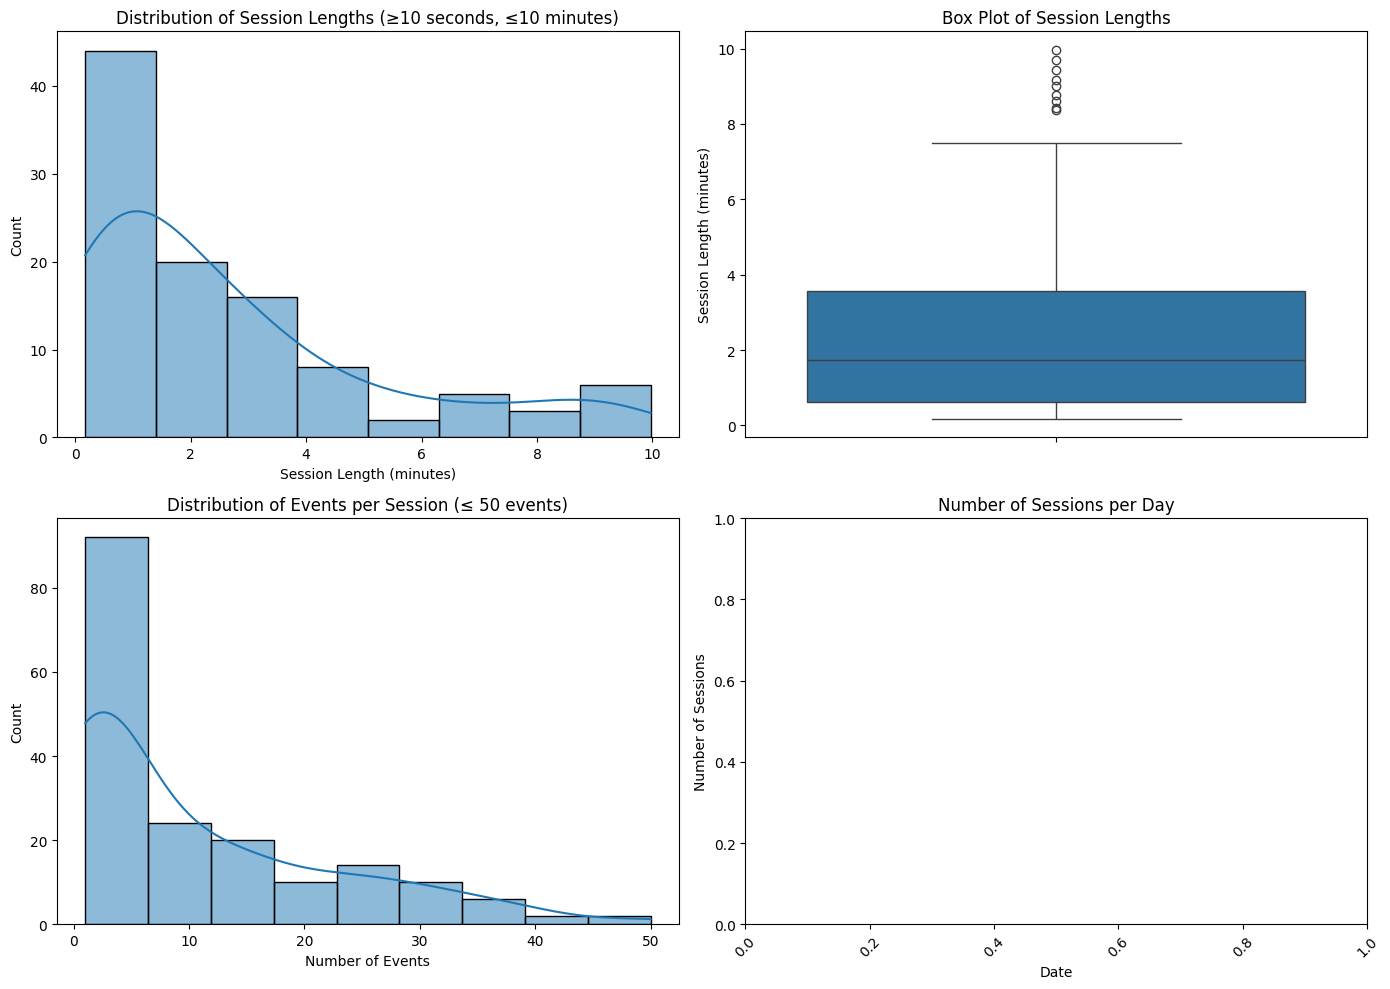

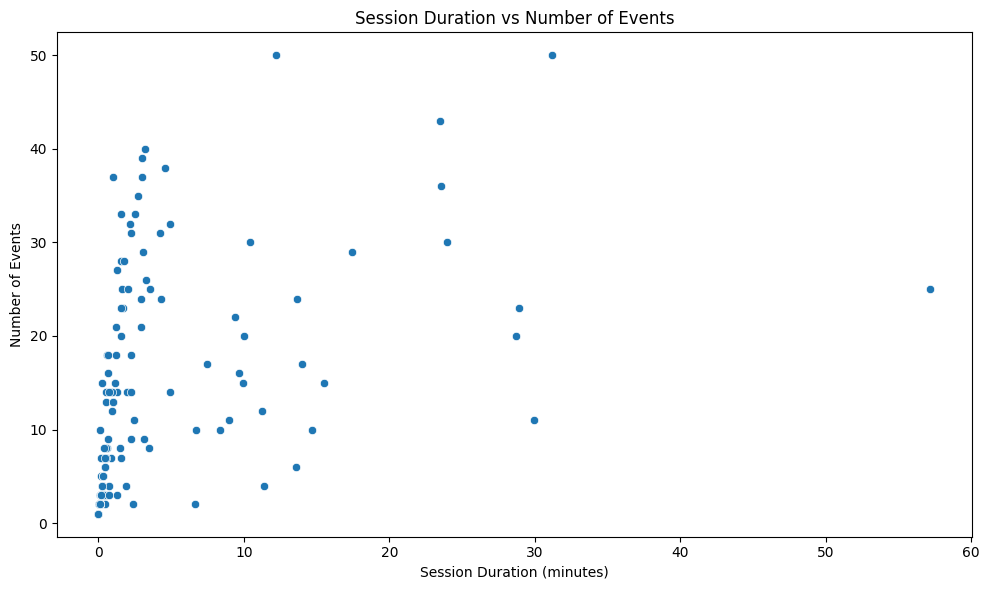

In [196]:

# 4. Create visualizations
plt.figure(figsize=(14, 10))

# Distribution of session lengths (in minutes)
plt.subplot(2, 2, 1)
# Filter out sessions longer than 60 minutes for better visualization

filtered_session_lengths = session_lengths[(1/6) <= session_lengths['duration_minutes']][session_lengths['duration_minutes'] <= 10]
sns.histplot(filtered_session_lengths['duration_minutes'], kde=True)
plt.title('Distribution of Session Lengths (≥10 seconds, ≤10 minutes)')
plt.xlabel('Session Length (minutes)')
plt.ylabel('Count')

# Box plot of session lengths
plt.subplot(2, 2, 2)
sns.boxplot(y=filtered_session_lengths['duration_minutes'])
plt.title('Box Plot of Session Lengths')
plt.ylabel('Session Length (minutes)')

# Events per session distribution
plt.subplot(2, 2, 3)
sns.histplot(events_per_session[events_per_session <= 50], kde=True)  # Filtering for better visualization
plt.title('Distribution of Events per Session (≤ 50 events)')
plt.xlabel('Number of Events')
plt.ylabel('Count')

# Session activity over time
plt.subplot(2, 2, 4)
sessions_per_day = pd.Series(session_lengths.index).groupby(
    [pd.to_datetime(session_lengths['start_time']).dt.date]
).count()
sns.lineplot(x=sessions_per_day.index, y=sessions_per_day.values)
plt.title('Number of Sessions per Day')
plt.xlabel('Date')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Additional visualization: Scatter plot of session duration vs number of events
plt.figure(figsize=(10, 6))
session_events_count = df_only_with_session.groupby('session_id').size().reset_index(name='event_count')
session_data = pd.merge(session_lengths.reset_index(), session_events_count, on='session_id')

# Filter for better visualization
filtered_session_data = session_data[
    (session_data['duration_minutes'] <= 60) & 
    (session_data['event_count'] <= 50)
]

sns.scatterplot(data=filtered_session_data, x='duration_minutes', y='event_count')
plt.title('Session Duration vs Number of Events')
plt.xlabel('Session Duration (minutes)')
plt.ylabel('Number of Events')
plt.tight_layout()
plt.show()

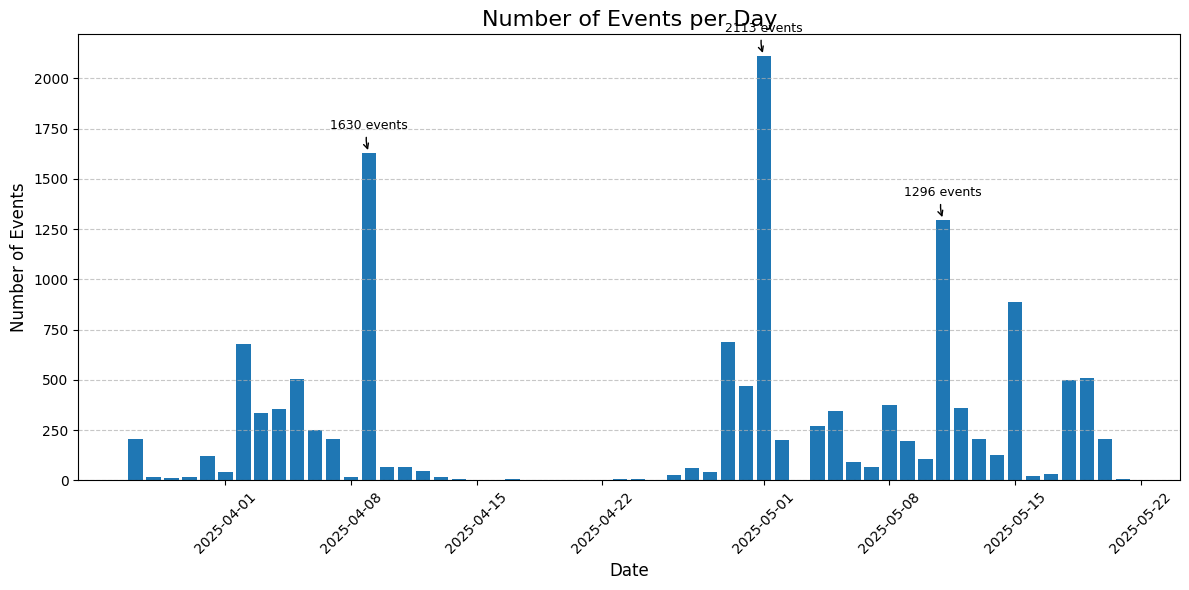

Total days with activity: 56
Average events per day: 246.84
Median events per day: 65.50
Day with most events: 2025-05-01 - 2113 events
Day with fewest events: 2025-04-20 - 1 events


/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_68723/490840090.py:52: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['created_at'].dt.to_period('M')


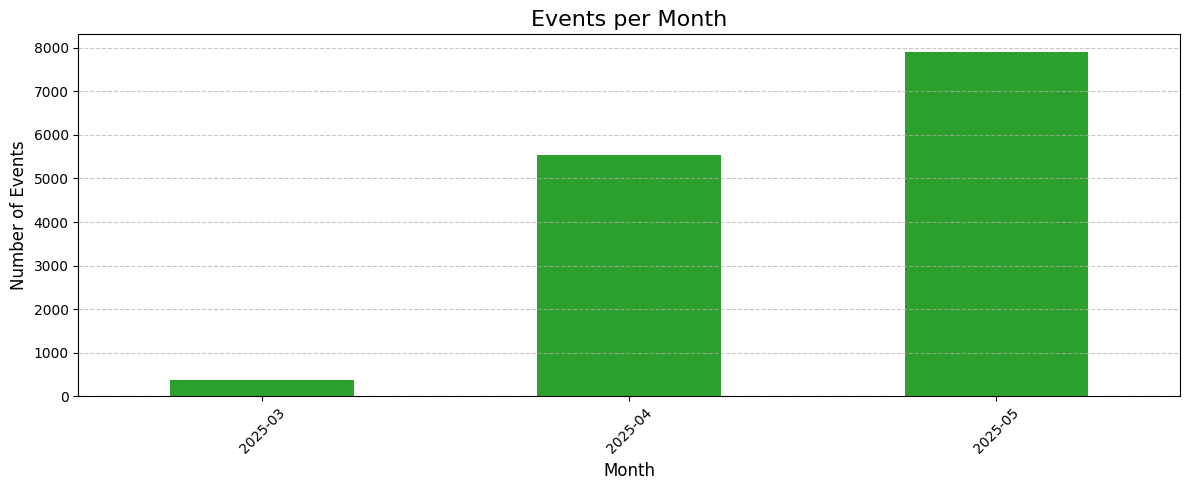

In [197]:
# Create a graph showing the amount of events sent per day

# Convert the created_at column to datetime if it's not already
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed', errors='coerce')

# Extract date from timestamp
df['date'] = df['created_at'].dt.date
df = df[df['date'] <= pd.to_datetime('2025-05-26').date()]

# Count events per day
events_per_day = df.groupby('date').size().reset_index(name='event_count')

# Plot the events per day
plt.figure(figsize=(12, 6))
plt.bar(events_per_day['date'], events_per_day['event_count'], color='#1f77b4')
plt.title('Number of Events per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Add annotations for significant peaks or valleys
# Find top 3 days with most events
top_days = events_per_day.nlargest(3, 'event_count')
for i, row in top_days.iterrows():
    plt.annotate(f"{row['event_count']} events",
                xy=(row['date'], row['event_count']),
                xytext=(0, 15),
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=9,
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

plt.show()

# Calculate daily statistics
total_days = len(events_per_day)
average_events_per_day = events_per_day['event_count'].mean()
median_events_per_day = events_per_day['event_count'].median()
max_events_day = events_per_day.loc[events_per_day['event_count'].idxmax()]
min_events_day = events_per_day.loc[events_per_day['event_count'].idxmin()]

print(f"Total days with activity: {total_days}")
print(f"Average events per day: {average_events_per_day:.2f}")
print(f"Median events per day: {median_events_per_day:.2f}")
print(f"Day with most events: {max_events_day['date']} - {max_events_day['event_count']} events")
print(f"Day with fewest events: {min_events_day['date']} - {min_events_day['event_count']} events")

# Create monthly aggregation to see trends
df['month'] = df['created_at'].dt.to_period('M')
events_per_month = df.groupby('month').size()

plt.figure(figsize=(12, 5))
events_per_month.plot(kind='bar', color='#2ca02c')
plt.title('Events per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

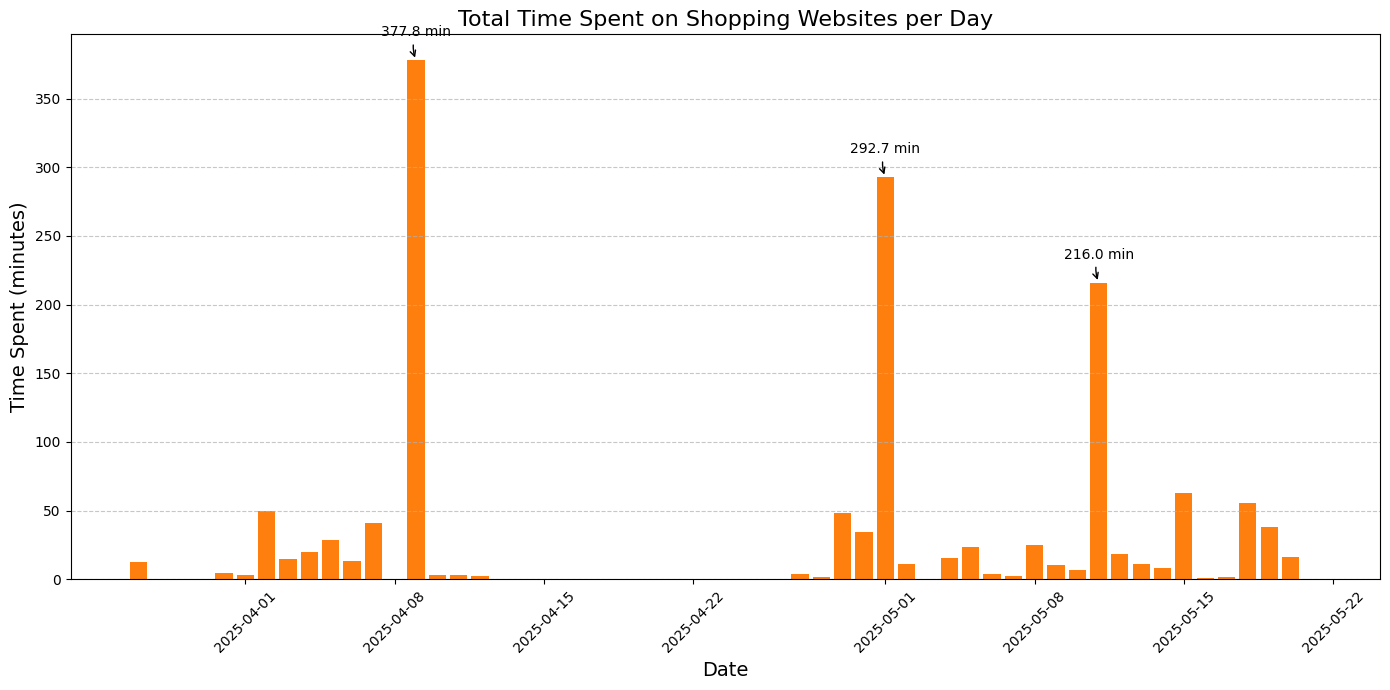

Total time spent on shopping websites: 1486.9 minutes (24.8 hours)
Average time spent per day: 35.4 minutes
Median time spent per day: 11.0 minutes
Day with most time spent: 2025-04-09 - 377.8 minutes


/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_68723/4129644655.py:66: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  time_spent_df['month'] = time_spent_df['created_at'].dt.to_period('M')


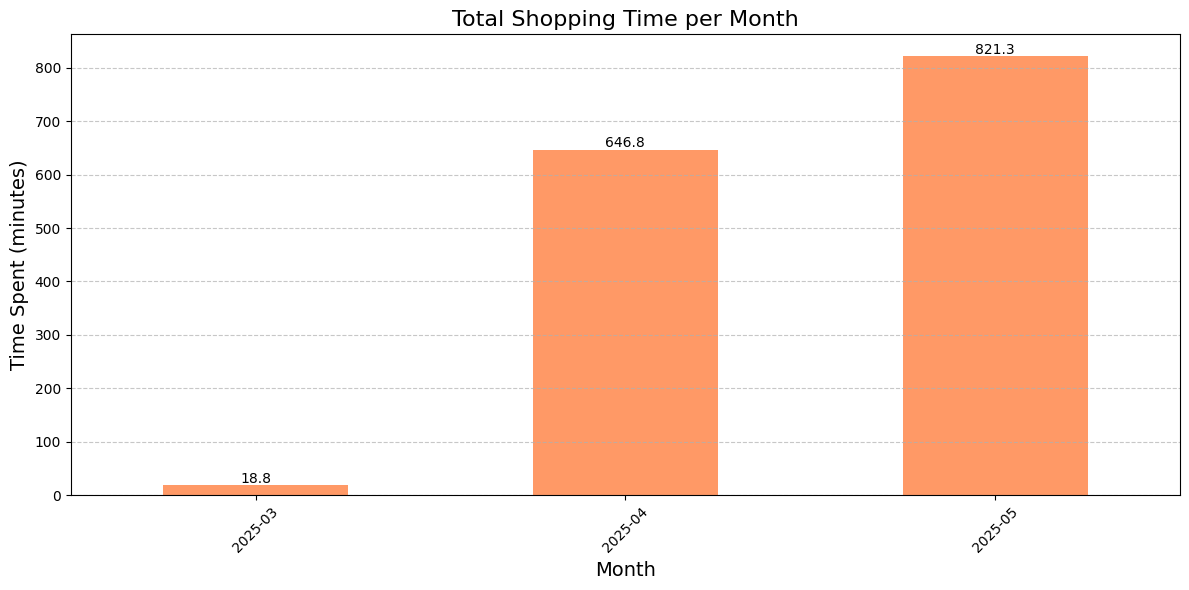

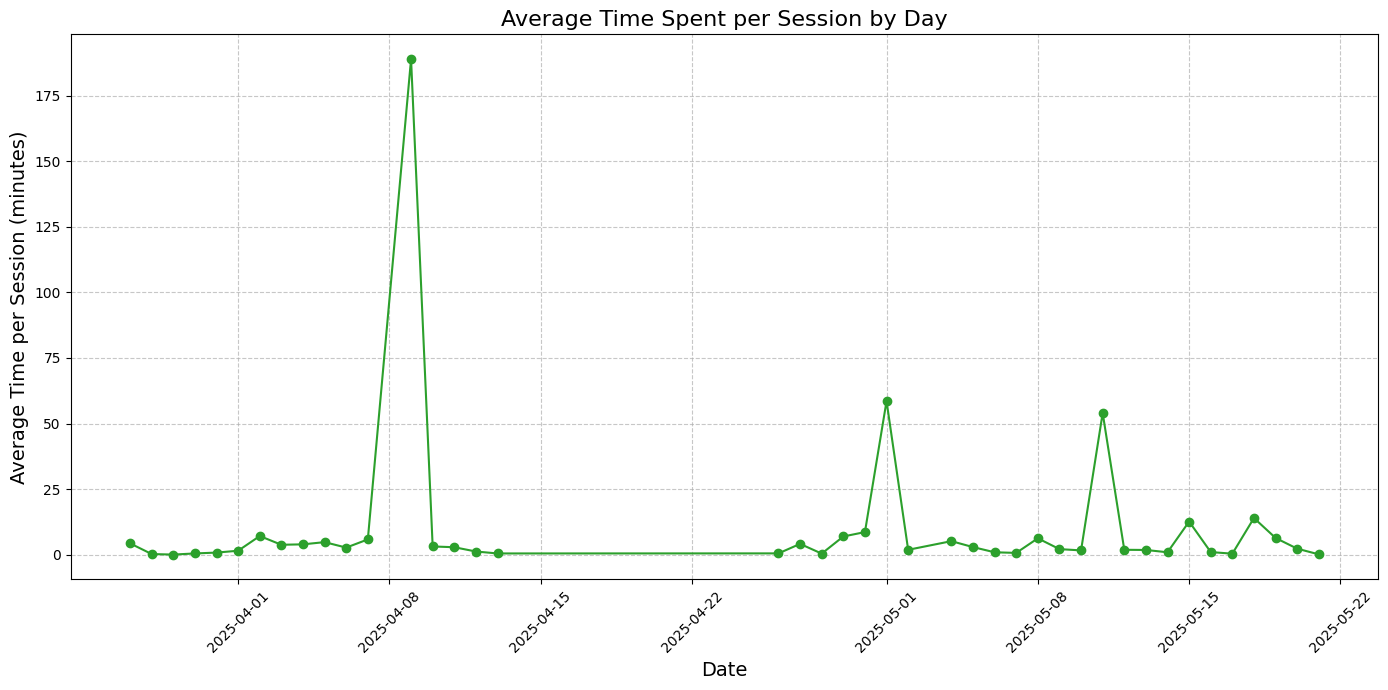

In [198]:
# Create a graph showing time spent on shopping websites each day
import json

# Filter to include only time-spent events
time_spent_df = df[df['type'] == 'time-spent'].copy()

# Convert created_at to datetime if not already
time_spent_df['created_at'] = pd.to_datetime(time_spent_df['created_at'], format='mixed', errors='coerce')

# Extract date from timestamp
time_spent_df['date'] = time_spent_df['created_at'].dt.date

# Extract duration from payload (convert from milliseconds to minutes)
def extract_duration(payload):
    try:
        # Parse the JSON payload
        data = json.loads(payload)
        # Get duration in milliseconds and convert to minutes
        duration_ms = data.get('duration', 0)
        return duration_ms / 60000  # Convert ms to minutes
    except (json.JSONDecodeError, TypeError):
        return 0

# Apply the function to extract durations
time_spent_df['duration_minutes'] = time_spent_df['payload'].apply(extract_duration)

# Aggregate time spent by date
daily_time_spent = time_spent_df.groupby('date')['duration_minutes'].sum().reset_index()

# Plot the time spent per day
plt.figure(figsize=(14, 7))
plt.bar(daily_time_spent['date'], daily_time_spent['duration_minutes'], color='#ff7f0e')
plt.title('Total Time Spent on Shopping Websites per Day', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Time Spent (minutes)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Add annotations for top days
top_time_days = daily_time_spent.nlargest(3, 'duration_minutes')
for i, row in top_time_days.iterrows():
    plt.annotate(f"{row['duration_minutes']:.1f} min",
                xy=(row['date'], row['duration_minutes']),
                xytext=(0, 15),
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=10,
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

plt.show()

# Calculate statistics
total_minutes_spent = daily_time_spent['duration_minutes'].sum()
average_minutes_per_day = daily_time_spent['duration_minutes'].mean()
median_minutes_per_day = daily_time_spent['duration_minutes'].median()
max_time_day = daily_time_spent.loc[daily_time_spent['duration_minutes'].idxmax()]

print(f"Total time spent on shopping websites: {total_minutes_spent:.1f} minutes ({total_minutes_spent/60:.1f} hours)")
print(f"Average time spent per day: {average_minutes_per_day:.1f} minutes")
print(f"Median time spent per day: {median_minutes_per_day:.1f} minutes")
print(f"Day with most time spent: {max_time_day['date']} - {max_time_day['duration_minutes']:.1f} minutes")

# Create monthly aggregation to see trends
time_spent_df['month'] = time_spent_df['created_at'].dt.to_period('M')
monthly_time_spent = time_spent_df.groupby('month')['duration_minutes'].sum()

plt.figure(figsize=(12, 6))
monthly_time_spent.plot(kind='bar', color='#ff9966')
plt.title('Total Shopping Time per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Time Spent (minutes)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for i, v in enumerate(monthly_time_spent):
    plt.text(i, v + 5, f"{v:.1f}", ha='center')

plt.show()

# Plot average time spent per user session
time_spent_with_session = time_spent_df[time_spent_df['session_id'] != 'none']
session_time_spent = time_spent_with_session.groupby(['date', 'session_id'])['duration_minutes'].sum()
avg_time_per_session = session_time_spent.groupby('date').mean().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(avg_time_per_session['date'], avg_time_per_session['duration_minutes'], 
         marker='o', linestyle='-', color='#2ca02c', markersize=6)
plt.title('Average Time Spent per Session by Day', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Time per Session (minutes)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

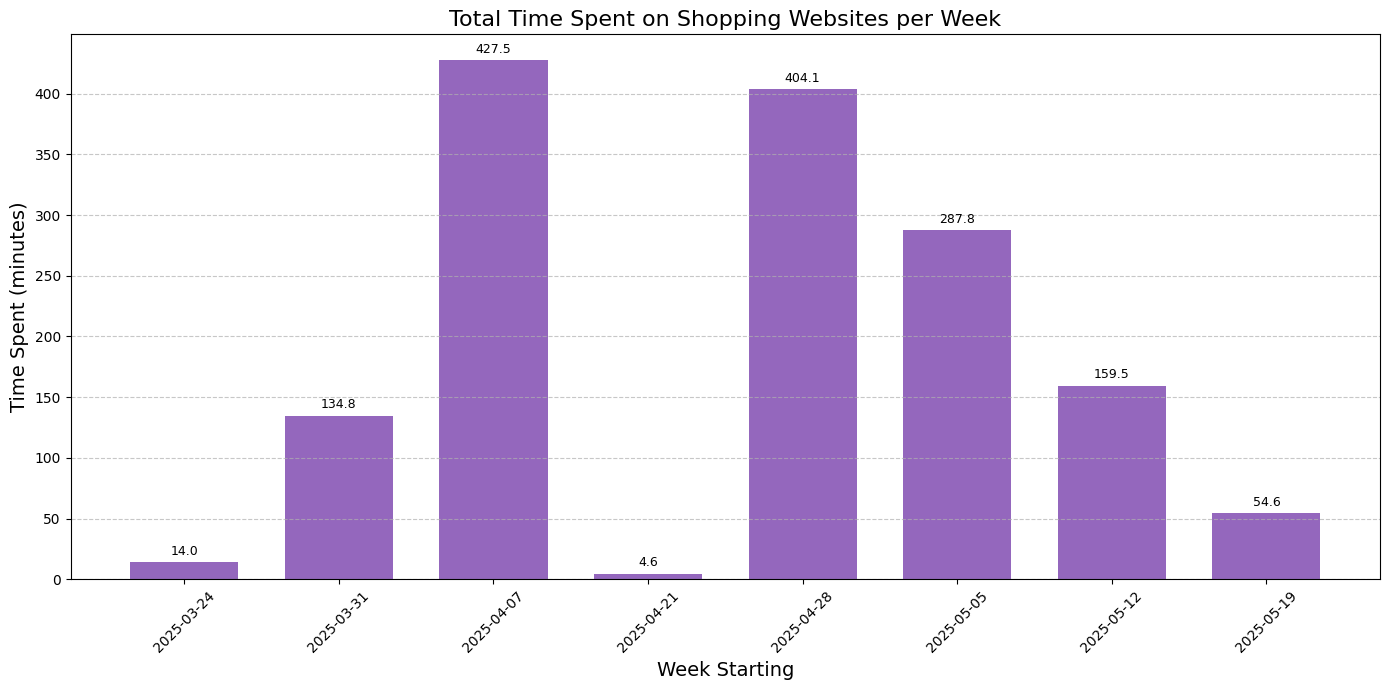

Total weeks analyzed: 8
Average time spent per week: 185.9 minutes (3.1 hours)
Median time spent per week: 147.1 minutes (2.5 hours)
Week with most time spent: Week starting 2025-04-07 - 427.5 minutes
Week with least time spent: Week starting 2025-04-21 - 4.6 minutes


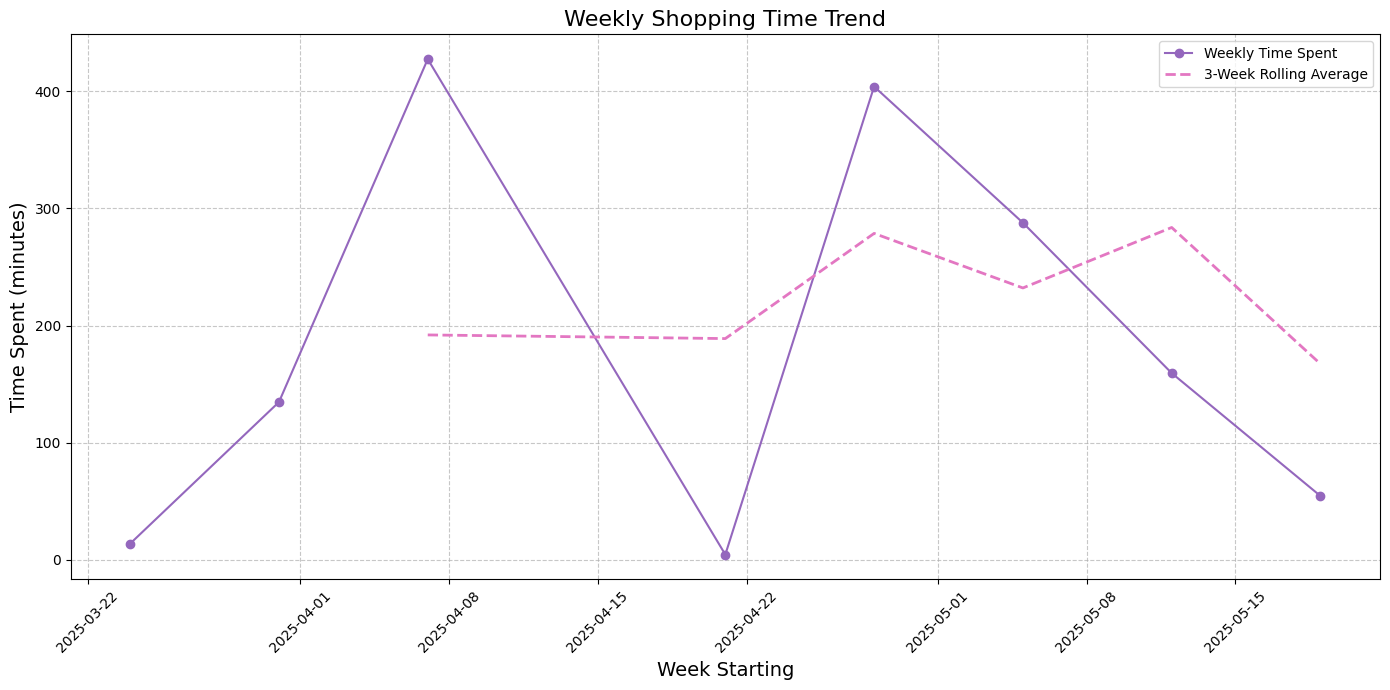

In [199]:
# Create a graph showing time spent on shopping websites per week
import json
from datetime import timedelta

# We can reuse the time_spent_df from the previous cell, but let's add week information
# Create a week column based on the date
# Ensure the 'date' column is in datetime format
time_spent_df['date'] = pd.to_datetime(time_spent_df['date'], errors='coerce')

# Calculate the week start date
time_spent_df['week_start'] = time_spent_df['date'] - pd.to_timedelta(time_spent_df['date'].dt.dayofweek, unit='d')
time_spent_df['week_label'] = time_spent_df['week_start'].dt.strftime('%Y-%m-%d')

# Aggregate time spent by week
weekly_time_spent = time_spent_df.groupby('week_label')['duration_minutes'].sum().reset_index()

# Sort by week (chronological order)
weekly_time_spent = weekly_time_spent.sort_values('week_label')

# Plot the time spent per week
plt.figure(figsize=(14, 7))
bars = plt.bar(weekly_time_spent['week_label'], weekly_time_spent['duration_minutes'], color='#9467bd', width=0.7)
plt.title('Total Time Spent on Shopping Websites per Week', fontsize=16)
plt.xlabel('Week Starting', fontsize=14)
plt.ylabel('Time Spent (minutes)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9)

plt.tight_layout()
plt.show()

# Calculate weekly statistics
total_weeks = len(weekly_time_spent)
average_minutes_per_week = weekly_time_spent['duration_minutes'].mean()
median_minutes_per_week = weekly_time_spent['duration_minutes'].median()
max_time_week = weekly_time_spent.loc[weekly_time_spent['duration_minutes'].idxmax()]
min_time_week = weekly_time_spent.loc[weekly_time_spent['duration_minutes'].idxmin()]

print(f"Total weeks analyzed: {total_weeks}")
print(f"Average time spent per week: {average_minutes_per_week:.1f} minutes ({average_minutes_per_week/60:.1f} hours)")
print(f"Median time spent per week: {median_minutes_per_week:.1f} minutes ({median_minutes_per_week/60:.1f} hours)")
print(f"Week with most time spent: Week starting {max_time_week['week_label']} - {max_time_week['duration_minutes']:.1f} minutes")
print(f"Week with least time spent: Week starting {min_time_week['week_label']} - {min_time_week['duration_minutes']:.1f} minutes")

# Additional visualization: Time spent trend with rolling average
plt.figure(figsize=(14, 7))

# Create date objects from week labels for proper time-series plotting
weekly_time_spent['week_date'] = pd.to_datetime(weekly_time_spent['week_label'])

# Plot the actual weekly data
plt.plot(weekly_time_spent['week_date'], weekly_time_spent['duration_minutes'], 
         marker='o', linestyle='-', color='#9467bd', label='Weekly Time Spent')

# Add a 3-week rolling average if we have enough data points
if len(weekly_time_spent) >= 3:
    rolling_avg = weekly_time_spent['duration_minutes'].rolling(window=3).mean()
    plt.plot(weekly_time_spent['week_date'], rolling_avg, 
             linestyle='--', linewidth=2, color='#e377c2', label='3-Week Rolling Average')

plt.title('Weekly Shopping Time Trend', fontsize=16)
plt.xlabel('Week Starting', fontsize=14)
plt.ylabel('Time Spent (minutes)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_68723/2355320534.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_df['created_at'] = pd.to_datetime(sessions_df['created_at'], format='mixed', errors='coerce')


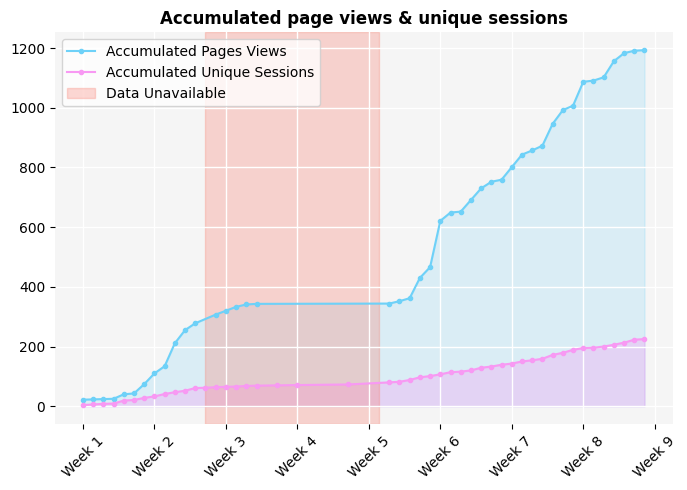

In [200]:
import os

# Also create a daily accumulation graph
# Make sure daily_clicks is sorted chronologically

# Filter for page-view events
sessions_df = df_only_with_session.drop_duplicates(subset=["session_id"])

# Convert created_at to datetime if not already
sessions_df['created_at'] = pd.to_datetime(sessions_df['created_at'], format='mixed', errors='coerce')
# Ensure the comparison is timezone-aware
sessions_df = sessions_df[sessions_df['created_at'] <= pd.to_datetime('2025-05-26', utc=True)]

# Extract date from timestamp
sessions_df['date'] = sessions_df['created_at'].dt.date

# Count the number of page-view events per date
sessions_df['event_count'] = 1
daily_sessions = sessions_df.groupby('date')['event_count'].sum().reset_index()

daily_sessions = daily_sessions.sort_values('date')

# Calculate cumulative sum of time spent
daily_sessions['cumulative_clicks'] = daily_sessions['event_count'].cumsum()



daily_spent_df = df[df['type'] == 'page-view'].copy()

# Convert created_at to datetime if not already
daily_spent_df['created_at'] = pd.to_datetime(daily_spent_df['created_at'], format='mixed', errors='coerce')
# Ensure the comparison is timezone-aware
daily_spent_df = daily_spent_df[daily_spent_df['created_at'] <= pd.to_datetime('2025-05-26', utc=True)]

# Extract date from timestamp
daily_spent_df['date'] = daily_spent_df['created_at'].dt.date

# Count the number of page-view events per date
daily_spent_df['event_count'] = 1
daily_clicks = daily_spent_df.groupby('date')['event_count'].sum().reset_index()

daily_clicks = daily_clicks.sort_values('date')

# Calculate cumulative sum of time spent
daily_clicks['cumulative_clicks'] = daily_clicks['event_count'].cumsum()

colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']

plt.figure(figsize=(7, 5))
plt.plot(daily_clicks['date'], daily_clicks['cumulative_clicks'], 
         marker='.', linestyle='-', color='#6ED1F8', linewidth=1.5, label='Accumulated Pages Views', zorder=2)
plt.plot(daily_sessions['date'], daily_sessions['cumulative_clicks'], 
         marker='.', linestyle='-', color='#F899F3', linewidth=1.5, label='Accumulated Unique Sessions', zorder=2)

# Fill the area under the curve
plt.fill_between(daily_clicks['date'], daily_clicks['cumulative_clicks'], 
                 alpha=0.2, color='#6ED1F8')

# Fill the area under the curve
plt.fill_between(daily_sessions['date'], daily_sessions['cumulative_clicks'], 
                 alpha=0.3, color='#F899F3')

plt.title('Accumulated page views & unique sessions', fontweight='bold')
# Set x-axis labels to week numbers starting from week 1
# Map x-ticks from date to week number
import matplotlib.dates as mdates
# Convert dates to datetime for week calculation
dates = pd.to_datetime(daily_clicks['date'])

# Calculate week number relative to the first date, then extend by one week
min_date = dates.min()
max_date = dates.max()
num_weeks = ((max_date - min_date).days // 7) + 1

# Extend by one additional week
extended_num_weeks = num_weeks + 1
extended_week_ends = [min_date + pd.Timedelta(days=7 * i) for i in range(extended_num_weeks + 1)]

# Set xticks at the start of each week, including the extra week
plt.xticks(
    extended_week_ends,
    [f"Week {i+1}" for i in range(extended_num_weeks + 1)],
    rotation=45
)

# Add a red vertical line at March 25
highlight_date = pd.to_datetime('2025-04-25')
highlight_date2 = pd.to_datetime('2025-04-08')
plt.axvspan(highlight_date2, highlight_date, color='salmon', alpha=0.3, label='Data Unavailable')

plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()

ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('./plots/cumulative-daily-views+sessions.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the plot with high resolution

/var/folders/3t/zxm5y0q90jz8w3yfmlvzj8mh0000gn/T/ipykernel_68723/1906013528.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_df['created_at'] = pd.to_datetime(sessions_df['created_at'], format='mixed', errors='coerce')


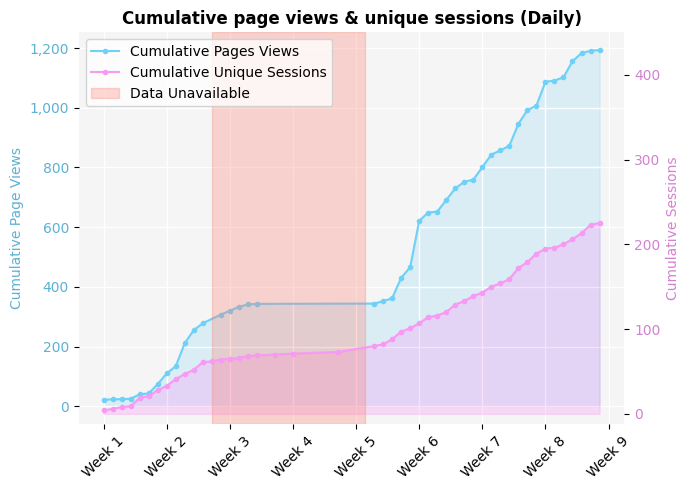

In [201]:
# Also create a daily accumulation graph
# Make sure daily_clicks is sorted chronologically

# Filter for page-view events
sessions_df = df_only_with_session.drop_duplicates(subset=["session_id"])

# Convert created_at to datetime if not already
sessions_df['created_at'] = pd.to_datetime(sessions_df['created_at'], format='mixed', errors='coerce')
# Ensure the comparison is timezone-aware
sessions_df = sessions_df[sessions_df['created_at'] <= pd.to_datetime('2025-05-26', utc=True)]

# Extract date from timestamp
sessions_df['date'] = sessions_df['created_at'].dt.date

# Count the number of page-view events per date
sessions_df['event_count'] = 1
daily_sessions = sessions_df.groupby('date')['event_count'].sum().reset_index()

daily_sessions = daily_sessions.sort_values('date')

# Calculate cumulative sum of time spent
daily_sessions['cumulative_clicks'] = daily_sessions['event_count'].cumsum()



daily_spent_df = df[df['type'] == 'page-view'].copy()

# Convert created_at to datetime if not already
daily_spent_df['created_at'] = pd.to_datetime(daily_spent_df['created_at'], format='mixed', errors='coerce')
# Ensure the comparison is timezone-aware
daily_spent_df = daily_spent_df[daily_spent_df['created_at'] <= pd.to_datetime('2025-05-26', utc=True)]

# Extract date from timestamp
daily_spent_df['date'] = daily_spent_df['created_at'].dt.date

# Count the number of page-view events per date
daily_spent_df['event_count'] = 1
daily_clicks = daily_spent_df.groupby('date')['event_count'].sum().reset_index()

daily_clicks = daily_clicks.sort_values('date')

# Calculate cumulative sum of time spent
daily_clicks['cumulative_clicks'] = daily_clicks['event_count'].cumsum()

colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']

plt.figure(figsize=(7, 5))
plt.plot(daily_clicks['date'], daily_clicks['cumulative_clicks'], 
         marker='.', linestyle='-', color='#6ED1F8', linewidth=1.5, label='Cumulative Pages Views', zorder=2)

# Fill the area under the curve
plt.fill_between(daily_clicks['date'], daily_clicks['cumulative_clicks'], 
                 alpha=0.2, color='#6ED1F8')

plt.title('Cumulative page views & unique sessions (Daily)', fontweight='bold')

# Function to darken a hex color
def darken_hex_color(hex_color, factor=0.7):
    """
    Darken a hex color by a factor (0-1)
    Lower factor = darker color
    """
    # Remove the # if present
    hex_color = hex_color.lstrip('#')
    
    # Convert hex to RGB
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    
    # Multiply each component by the factor
    r = max(0, int(r * factor))
    g = max(0, int(g * factor))
    b = max(0, int(b * factor))
    
    # Convert back to hex
    return f"#{r:02x}{g:02x}{b:02x}"

# Create darker versions of colors for better visibility
dark_blue = darken_hex_color('#6ED1F8', 0.85)
dark_pink = darken_hex_color('#F899F3', 0.85)


ax = plt.gca()
ax.set_ylabel('Cumulative Page Views', color=dark_blue)
ax.tick_params(axis='y', labelcolor=dark_blue)
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Convert dates to datetime for week calculation
dates = pd.to_datetime(daily_clicks['date'])

# Calculate week number relative to the first date, then extend by one week
min_date = dates.min()
max_date = dates.max()
num_weeks = ((max_date - min_date).days // 7) + 1

# Extend by one additional week
extended_num_weeks = num_weeks + 1
extended_week_ends = [min_date + pd.Timedelta(days=7 * i) for i in range(extended_num_weeks + 1)]

# Set xticks at the start of each week, including the extra week
plt.xticks(
    extended_week_ends,
    [f"Week {i+1}" for i in range(extended_num_weeks + 1)],
    rotation=45
)
# Format y-axis with commas for thousands separator
plt.gca().get_yaxis().set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Create a twin axis for the sessions data
ax2 = plt.gca().twinx()
ax2.plot(daily_sessions['date'], daily_sessions['cumulative_clicks'], 
         marker='.', linestyle='-', color='#F899F3', linewidth=1.5, label='Cumulative Unique Sessions', zorder=2)
ax2.fill_between(daily_sessions['date'], daily_sessions['cumulative_clicks'], 
                 alpha=0.3, color='#F899F3')

ax2.set_ylim(-12, daily_sessions['cumulative_clicks'].max() * 2)  # Set y-limits for the second axis

ax2.set_ylabel('Cumulative Sessions', color=dark_pink)
ax2.tick_params(axis='y', labelcolor=dark_pink)
ax2.format_coord = lambda x, y: f"x={x:.2f}, y={y:.2f}"
ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Readjust the legend
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1))
# Add a red vertical line at March 25
highlight_date = pd.to_datetime('2025-04-25')
highlight_date2 = pd.to_datetime('2025-04-08')
plt.axvspan(highlight_date2, highlight_date, color='salmon', alpha=0.3, label='Data Unavailable')

# Get handles and labels from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels from both axes
lines = lines1 + lines2
labels = labels1 + labels2

# Create a unified legend
plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()

plt.show()

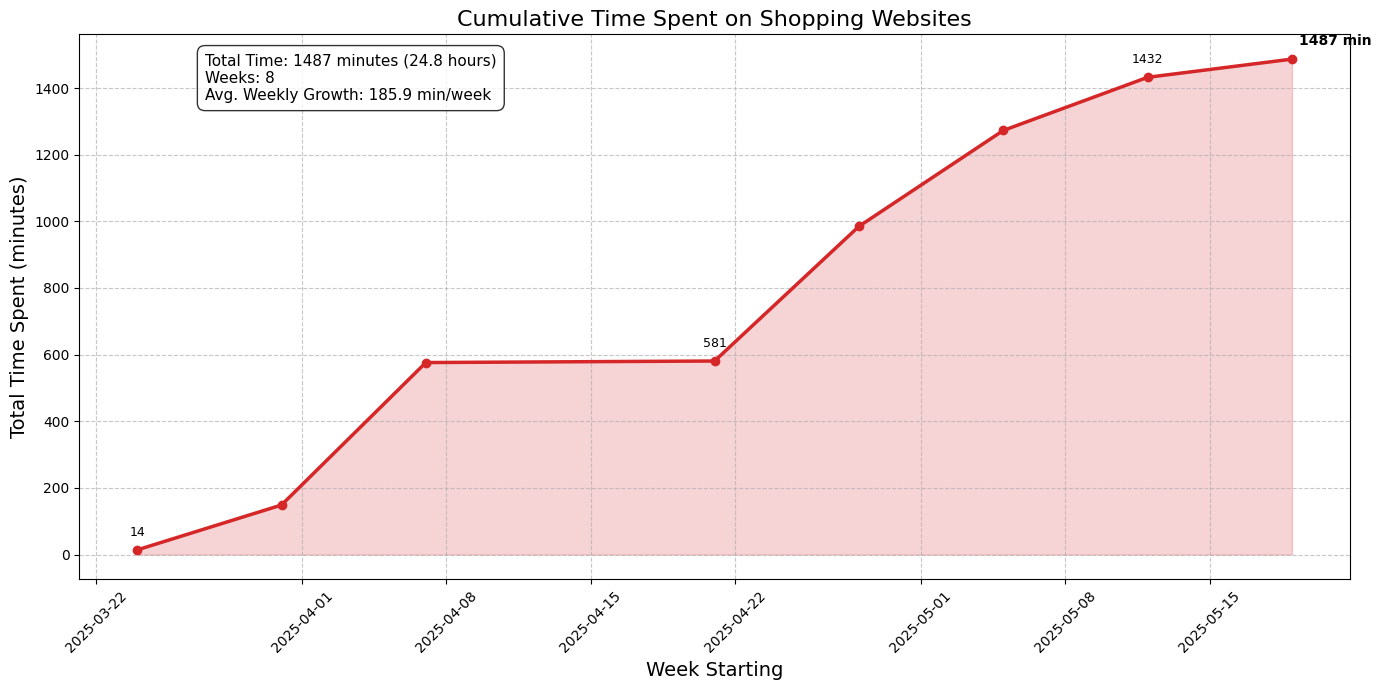

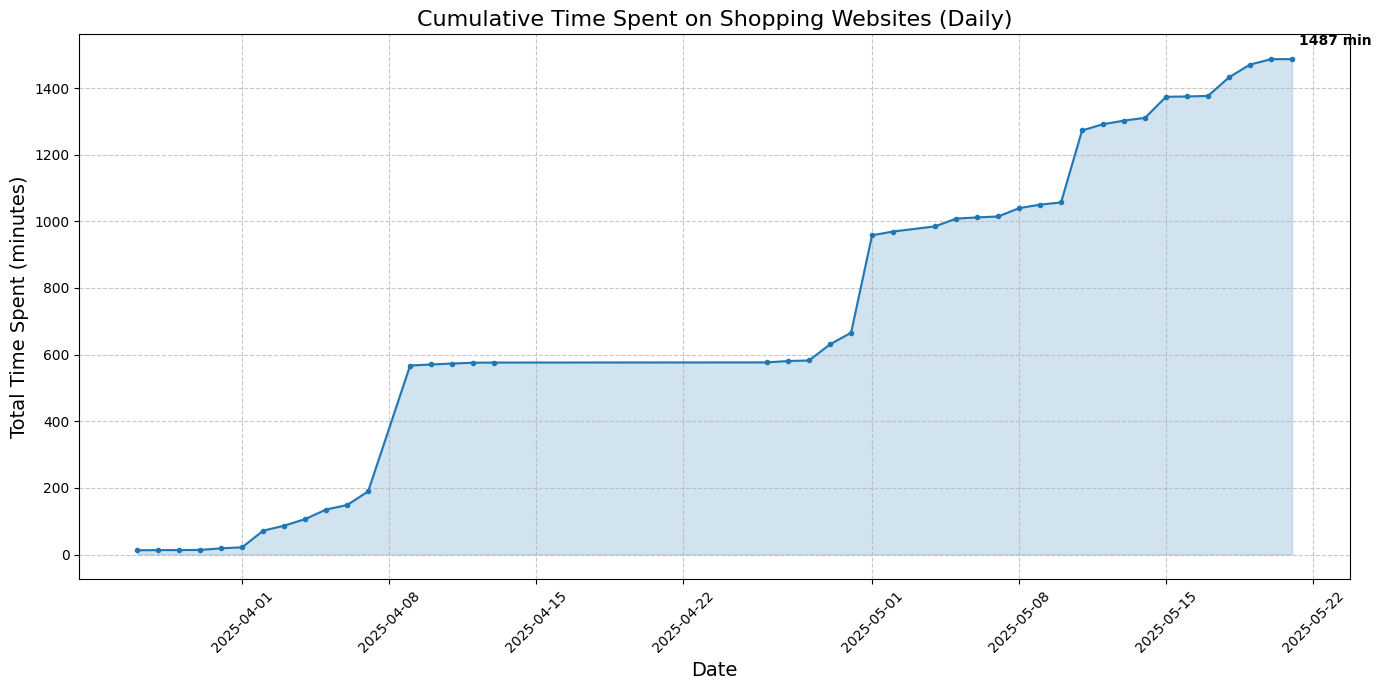

In [202]:
# Create an accumulation graph of time spent on shopping websites over weeks
plt.figure(figsize=(14, 7))

# Make sure weekly_time_spent is sorted chronologically
weekly_time_spent = weekly_time_spent.sort_values('week_date')

# Calculate cumulative sum of time spent
weekly_time_spent['cumulative_minutes'] = weekly_time_spent['duration_minutes'].cumsum()

# Create the accumulation line chart
plt.plot(weekly_time_spent['week_date'], weekly_time_spent['cumulative_minutes'], 
         marker='o', linestyle='-', color='#d62728', linewidth=2.5)

# Fill the area under the curve
plt.fill_between(weekly_time_spent['week_date'], weekly_time_spent['cumulative_minutes'], 
                 alpha=0.2, color='#d62728')

# Add data labels at key points
# Label every 3rd point to avoid overcrowding
for i, row in weekly_time_spent.iloc[::3].iterrows():
    plt.annotate(f"{row['cumulative_minutes']:.0f}",
                xy=(row['week_date'], row['cumulative_minutes']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9)

# Always label the last point
last_point = weekly_time_spent.iloc[-1]
plt.annotate(f"{last_point['cumulative_minutes']:.0f} min",
            xy=(last_point['week_date'], last_point['cumulative_minutes']),
            xytext=(5, 10),
            textcoords='offset points',
            ha='left',
            fontsize=10,
            fontweight='bold')

plt.title('Cumulative Time Spent on Shopping Websites', fontsize=16)
plt.xlabel('Week Starting', fontsize=14)
plt.ylabel('Total Time Spent (minutes)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Add average weekly growth rate
avg_weekly_growth = weekly_time_spent['duration_minutes'].mean()
total_time = weekly_time_spent['cumulative_minutes'].iloc[-1]
total_weeks = len(weekly_time_spent)

# Add text box with statistics
stats_text = (
    f"Total Time: {total_time:.0f} minutes ({total_time/60:.1f} hours)\n"
    f"Weeks: {total_weeks}\n"
    f"Avg. Weekly Growth: {avg_weekly_growth:.1f} min/week"
)
plt.figtext(0.15, 0.85, stats_text, fontsize=11, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.show()

# Also create a daily accumulation graph
# Make sure daily_time_spent is sorted chronologically
daily_time_spent = daily_time_spent.sort_values('date')

# Calculate cumulative sum of time spent
daily_time_spent['cumulative_minutes'] = daily_time_spent['duration_minutes'].cumsum()

plt.figure(figsize=(14, 7))
plt.plot(daily_time_spent['date'], daily_time_spent['cumulative_minutes'], 
         marker='.', linestyle='-', color='#1f77b4', linewidth=1.5)

# Fill the area under the curve
plt.fill_between(daily_time_spent['date'], daily_time_spent['cumulative_minutes'], 
                 alpha=0.2, color='#1f77b4')

# Add label for the last point
last_point = daily_time_spent.iloc[-1]
plt.annotate(f"{last_point['cumulative_minutes']:.0f} min",
            xy=(last_point['date'], last_point['cumulative_minutes']),
            xytext=(5, 10),
            textcoords='offset points',
            ha='left',
            fontsize=10,
            fontweight='bold')

plt.title('Cumulative Time Spent on Shopping Websites (Daily)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Time Spent (minutes)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

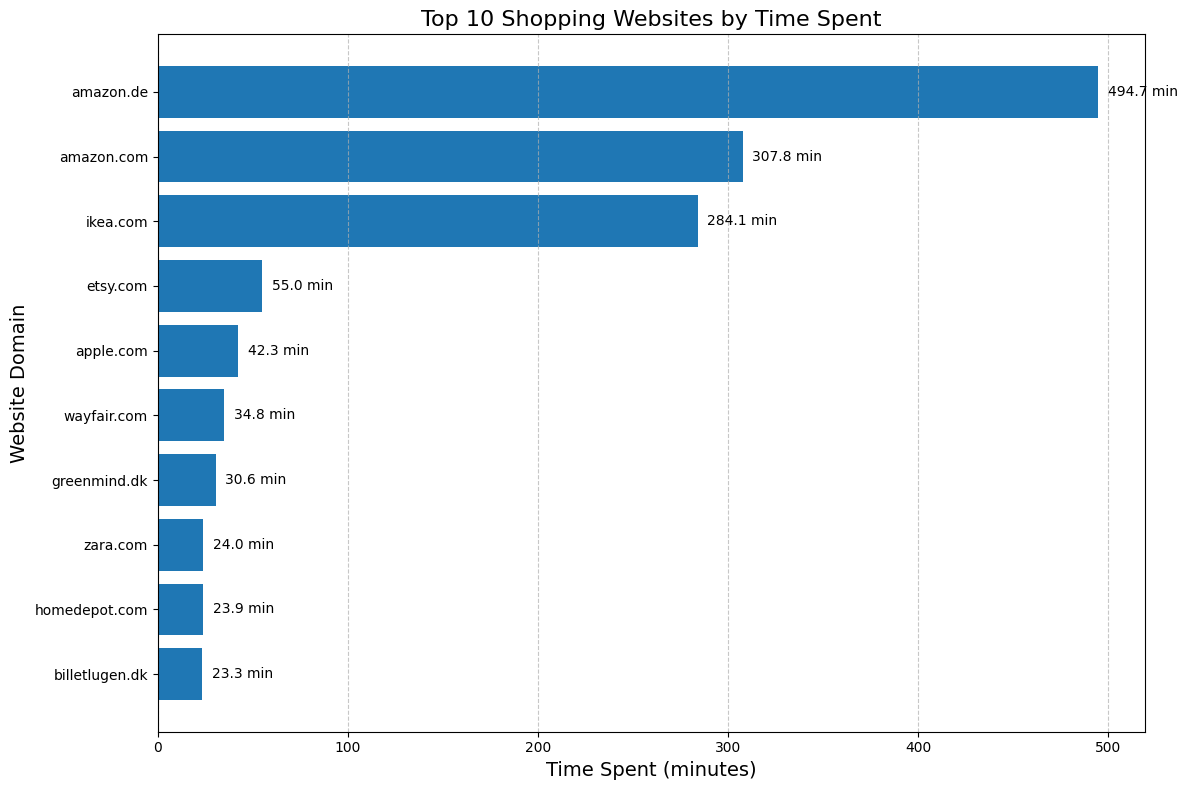

Total unique websites visited: 42
Total time spent on all websites: 1486.9 minutes (24.8 hours)
Average time per website: 35.4 minutes
Median time per website: 6.7 minutes
Top 10 websites account for 88.8% of total shopping time


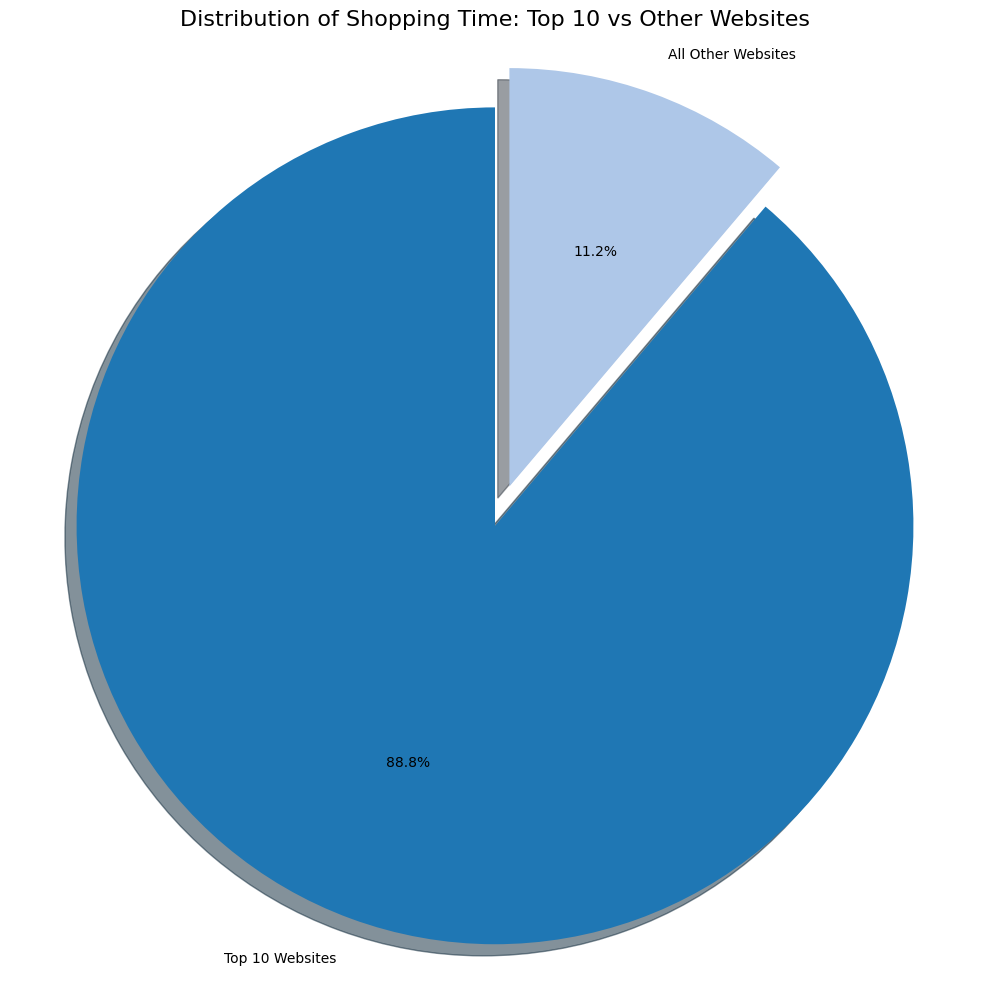


Top 10 Websites by Time Spent:
       Website  Minutes  Hours  % of Total Time
     amazon.de    494.7   8.25             33.3
    amazon.com    307.8   5.13             20.7
      ikea.com    284.1   4.73             19.1
      etsy.com     55.0   0.92              3.7
     apple.com     42.3   0.71              2.8
   wayfair.com     34.8   0.58              2.3
  greenmind.dk     30.6   0.51              2.1
      zara.com     24.0   0.40              1.6
 homedepot.com     23.9   0.40              1.6
billetlugen.dk     23.3   0.39              1.6


In [203]:
# Create a chart showing the top 10 most popular shopping websites by time spent

# We can use the time_spent_df from previous cells which already has extracted durations
# Group by domain to get the most popular shopping websites
website_time_spent = time_spent_df.groupby('domain')['duration_minutes'].sum().reset_index()

# Sort by time spent in descending order and get top 10
top10_websites = website_time_spent.sort_values('duration_minutes', ascending=False).head(10)

# Create a horizontal bar chart for better readability of domain names
plt.figure(figsize=(12, 8))
bars = plt.barh(top10_websites['domain'], top10_websites['duration_minutes'], color='#1f77b4')
plt.title('Top 10 Shopping Websites by Time Spent', fontsize=16)
plt.xlabel('Time Spent (minutes)', fontsize=14)
plt.ylabel('Website Domain', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis to show highest value at the top

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 5
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.1f} min',
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate statistics about website visits
total_websites = len(website_time_spent)
total_time_minutes = website_time_spent['duration_minutes'].sum()
avg_time_per_website = website_time_spent['duration_minutes'].mean()
median_time_per_website = website_time_spent['duration_minutes'].median()
top10_time_percentage = top10_websites['duration_minutes'].sum() / total_time_minutes * 100

print(f"Total unique websites visited: {total_websites}")
print(f"Total time spent on all websites: {total_time_minutes:.1f} minutes ({total_time_minutes/60:.1f} hours)")
print(f"Average time per website: {avg_time_per_website:.1f} minutes")
print(f"Median time per website: {median_time_per_website:.1f} minutes")
print(f"Top 10 websites account for {top10_time_percentage:.1f}% of total shopping time")

# Create a pie chart to visualize the distribution of time between top websites and others
plt.figure(figsize=(10, 10))
top10_time = top10_websites['duration_minutes'].sum()
other_time = total_time_minutes - top10_time
sizes = [top10_time, other_time]
labels = ['Top 10 Websites', 'All Other Websites']
colors = ['#1f77b4', '#aec7e8']
explode = (0.1, 0)  # explode the 1st slice (Top 10)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Shopping Time: Top 10 vs Other Websites', fontsize=16)
plt.tight_layout()
plt.show()

# Create a detailed table for the top 10 websites
# Calculate percentage of total time for each website
top10_websites['percentage'] = top10_websites['duration_minutes'] / total_time_minutes * 100
top10_websites['hours'] = top10_websites['duration_minutes'] / 60
top10_detailed = top10_websites[['domain', 'duration_minutes', 'hours', 'percentage']]
top10_detailed = top10_detailed.round({'duration_minutes': 1, 'hours': 2, 'percentage': 1})
top10_detailed = top10_detailed.rename(columns={
    'domain': 'Website',
    'duration_minutes': 'Minutes',
    'hours': 'Hours',
    'percentage': '% of Total Time'
})

# Display the table
print("\nTop 10 Websites by Time Spent:")
print(top10_detailed.to_string(index=False))

Total add-to-cart events captured: 54
Number of users who added items to cart: 13
Average add-to-cart events per user: 4.15
Median add-to-cart events per user: 3.00


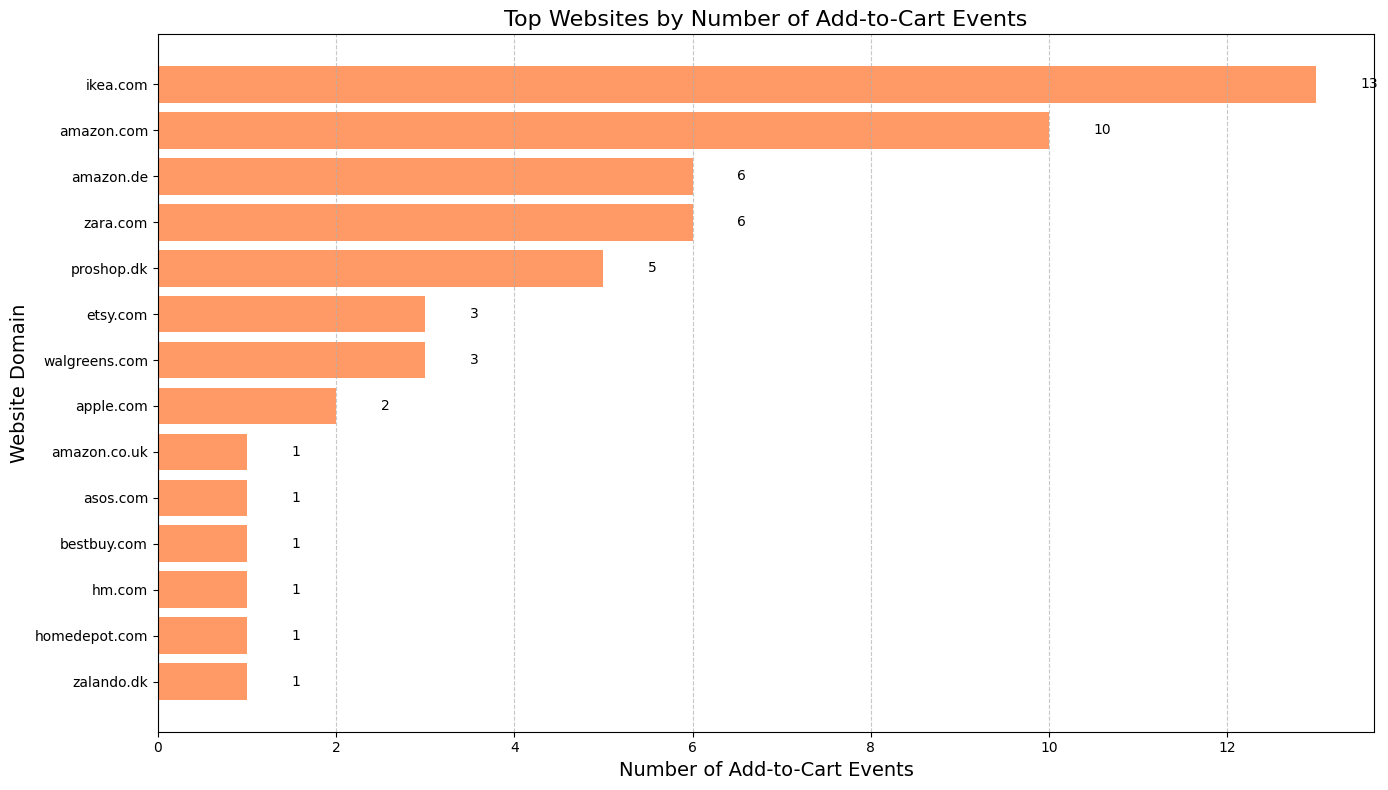


Top 10 Websites by Add-to-Cart Events:
      Website  Add-to-Cart Events  % of Total
     ikea.com                  13        24.1
   amazon.com                  10        18.5
    amazon.de                   6        11.1
     zara.com                   6        11.1
   proshop.dk                   5         9.3
     etsy.com                   3         5.6
walgreens.com                   3         5.6
    apple.com                   2         3.7
 amazon.co.uk                   1         1.9
     asos.com                   1         1.9


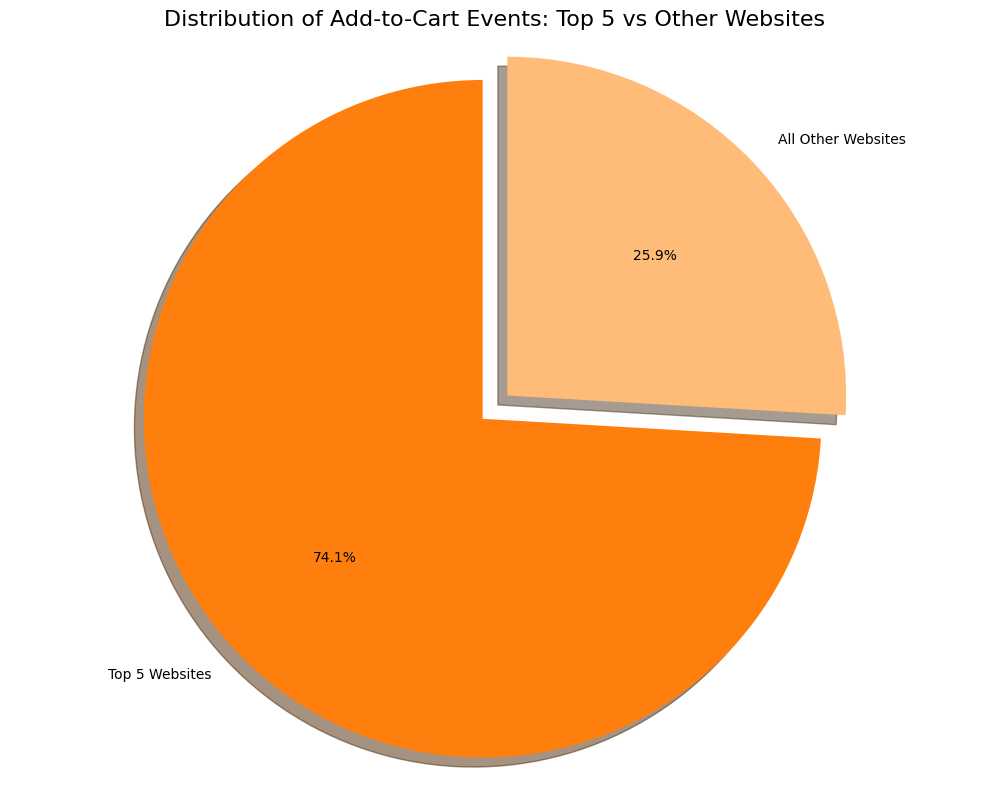

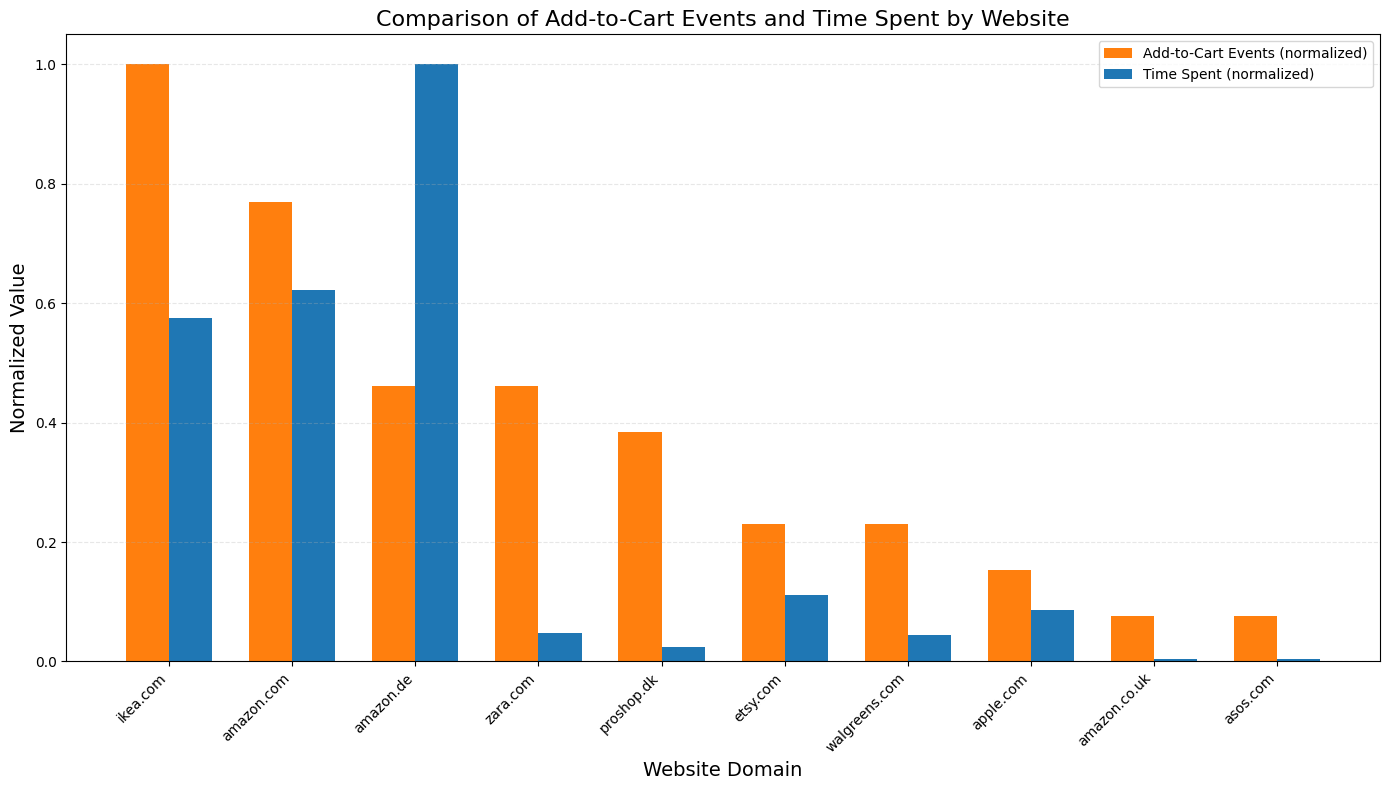


Comparison of Add-to-Cart Events and Time Spent:
      Website  Cart Events  Time Spent (min)  Cart Events/Minute
     ikea.com           13             284.1               0.046
   amazon.com           10             307.8               0.032
    amazon.de            6             494.7               0.012
     zara.com            6              24.0               0.250
   proshop.dk            5              12.2               0.409
     etsy.com            3              55.0               0.055
walgreens.com            3              21.7               0.138
    apple.com            2              42.3               0.047
 amazon.co.uk            1               2.1               0.484
     asos.com            1               1.7               0.580


In [204]:
# Analyze add-to-cart events per website

# Filter to include only add-to-cart events
add_to_cart_df = df[df['type'] == 'add-to-cart'].copy()

# Check the total number of add-to-cart events captured
total_add_to_cart = len(add_to_cart_df)
print(f"Total add-to-cart events captured: {total_add_to_cart}")

# Count add-to-cart events per user
add_to_cart_per_user = add_to_cart_df.groupby('user_id').size().reset_index(name='cart_count')
users_with_cart_events = len(add_to_cart_per_user)
print(f"Number of users who added items to cart: {users_with_cart_events}")
print(f"Average add-to-cart events per user: {add_to_cart_per_user['cart_count'].mean():.2f}")
print(f"Median add-to-cart events per user: {add_to_cart_per_user['cart_count'].median():.2f}")

# Count add-to-cart events per website
add_to_cart_per_site = add_to_cart_df.groupby('domain').size().reset_index(name='cart_count')
add_to_cart_per_site = add_to_cart_per_site.sort_values('cart_count', ascending=False)

# Plot the top 15 websites with most add-to-cart events
plt.figure(figsize=(14, 8))
top_sites = add_to_cart_per_site.head(15)

# Create horizontal bar chart
bars = plt.barh(top_sites['domain'], top_sites['cart_count'], color='#ff9966')
plt.title('Top Websites by Number of Add-to-Cart Events', fontsize=16)
plt.xlabel('Number of Add-to-Cart Events', fontsize=14)
plt.ylabel('Website Domain', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis to show highest value at the top

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.5
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{int(width)}',
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate percentage of total add-to-cart events for each website
total_cart_events = add_to_cart_per_site['cart_count'].sum()
add_to_cart_per_site['percentage'] = (add_to_cart_per_site['cart_count'] / total_cart_events * 100).round(1)

# Create detailed view of top 10 websites
top10_cart_sites = add_to_cart_per_site.head(10)
print("\nTop 10 Websites by Add-to-Cart Events:")
print(top10_cart_sites[['domain', 'cart_count', 'percentage']].rename(
    columns={'domain': 'Website', 'cart_count': 'Add-to-Cart Events', 'percentage': '% of Total'}
).to_string(index=False))

# Create pie chart for top 5 vs others
plt.figure(figsize=(10, 8))
top5_sites = add_to_cart_per_site.head(5)
top5_count = top5_sites['cart_count'].sum()
others_count = total_cart_events - top5_count

# Create pie chart data
sizes = [top5_count, others_count]
labels = ['Top 5 Websites', 'All Other Websites']
colors = ['#ff7f0e', '#ffbb78']
explode = (0.1, 0)  # explode the 1st slice (Top 5)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Add-to-Cart Events: Top 5 vs Other Websites', fontsize=16)
plt.tight_layout()
plt.show()

# Compare add-to-cart events with time spent on websites
if 'time_spent_df' in locals():
    # Get top domains from both datasets
    top_cart_domains = set(top10_cart_sites['domain'])
    
    # Filter time spent data for domains with cart events
    time_for_cart_domains = website_time_spent[website_time_spent['domain'].isin(top_cart_domains)]
    
    # Merge datasets
    merged_df = pd.merge(top10_cart_sites, time_for_cart_domains, on='domain', how='left')
    merged_df = merged_df.fillna(0)
    merged_df = merged_df.rename(columns={'cart_count': 'add_to_cart_events', 'duration_minutes': 'time_spent_minutes'})
    
    # Calculate events per minute
    merged_df['events_per_minute'] = merged_df.apply(
        lambda row: row['add_to_cart_events'] / row['time_spent_minutes'] if row['time_spent_minutes'] > 0 else 0, 
        axis=1
    )
    
    # Sort by add-to-cart events
    merged_df = merged_df.sort_values('add_to_cart_events', ascending=False)
    
    # Create a comparison plot
    plt.figure(figsize=(14, 8))
    
    domains = merged_df['domain']
    x = np.arange(len(domains))
    width = 0.35
    
    # Normalize the values for better comparison
    max_cart = merged_df['add_to_cart_events'].max()
    max_time = merged_df['time_spent_minutes'].max()
    
    normalized_cart = merged_df['add_to_cart_events'] / max_cart
    normalized_time = merged_df['time_spent_minutes'] / max_time
    
    # Plot bars
    plt.bar(x - width/2, normalized_cart, width, label='Add-to-Cart Events (normalized)', color='#ff7f0e')
    plt.bar(x + width/2, normalized_time, width, label='Time Spent (normalized)', color='#1f77b4')
    
    plt.xlabel('Website Domain', fontsize=14)
    plt.ylabel('Normalized Value', fontsize=14)
    plt.title('Comparison of Add-to-Cart Events and Time Spent by Website', fontsize=16)
    plt.xticks(x, domains, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Display the detailed statistics
    print("\nComparison of Add-to-Cart Events and Time Spent:")
    display_df = merged_df[['domain', 'add_to_cart_events', 'time_spent_minutes', 'events_per_minute']]
    display_df = display_df.round({'time_spent_minutes': 1, 'events_per_minute': 3})
    display_df = display_df.rename(columns={
        'domain': 'Website',
        'add_to_cart_events': 'Cart Events',
        'time_spent_minutes': 'Time Spent (min)',
        'events_per_minute': 'Cart Events/Minute'
    })
    print(display_df.to_string(index=False))

In [205]:
# Enhanced Shopping Behavior Analysis - Checkout, Modal, Purchase Comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# === 1. ADD-TO-CART EVENTS (from previous analysis) ===
add_to_cart_df = df[df['type'] == 'add-to-cart'].copy()
add_to_cart_per_site = add_to_cart_df.groupby('domain').size().reset_index(name='cart_count')
add_to_cart_per_site = add_to_cart_per_site.sort_values('cart_count', ascending=False)
top10_cart_sites = add_to_cart_per_site.head(10).copy()

# === 2. CHECKOUT PAGE VISITS ===
# Filter for URLs containing "/checkout"
checkout_df = df[df['url'].str.contains('/checkout|/cart|/shoppingcart|/bag', case=False, na=False)].copy()
print(f"Total checkout page visits: {len(checkout_df)}")

# Count unique sessions with checkout page visits
# Count unique (session_id, domain) pairs for checkout page visits
checkout_session_domains = checkout_df[['session_id', 'domain']].drop_duplicates()
checkout_session_domain_count = checkout_session_domains.shape[0]
print(f"Number of unique (session, website) pairs with checkout visits: {checkout_session_domain_count}")

# Count checkout visits per website
checkout_per_site = checkout_df.groupby('domain').size().reset_index(name='checkout_count')
checkout_per_site = checkout_per_site.sort_values('checkout_count', ascending=False)
top_checkout_sites = checkout_per_site.head(10)

print("\nTop websites by checkout visits:")
display(top_checkout_sites)

# === 3. ANTI-IMPULSE MODAL DISPLAY ===
# Filter for enforce_wait_modal_shown events
modal_df = df[df['type'] == 'enforce_wait_modal_shown'].copy()
print(f"\nTotal anti-impulse modal displays: {len(modal_df)}")

# Count unique sessions where modal was shown
modal_sessions = modal_df['session_id'].nunique()
print(f"Number of sessions where anti-impulse modal was shown: {modal_sessions}")

# Count modal displays per website
modal_per_site = modal_df.groupby('domain').size().reset_index(name='modal_count')
modal_per_site = modal_per_site.sort_values('modal_count', ascending=False)
top_modal_sites = modal_per_site.head(10)

print("\nTop websites by modal displays:")
display(top_modal_sites)

# === 4. PURCHASE / PLACE-ORDER EVENTS ===
# Filter for place-order events
purchase_df = df[df['type'] == 'place-order'].copy()
print(f"\nTotal purchase/place-order events: {len(purchase_df)}")

# Count unique sessions with purchases
purchase_sessions = purchase_df['session_id'].nunique()
print(f"Number of sessions with completed purchases: {purchase_sessions}")

# Count purchases per website
purchase_per_site = purchase_df.groupby('domain').size().reset_index(name='purchase_count')
purchase_per_site = purchase_per_site.sort_values('purchase_count', ascending=False)
top_purchase_sites = purchase_per_site.head(10)

print("\nTop websites by purchases:")
display(top_purchase_sites)

# === 5. TIME SPENT DATA (for comparison) ===
# Reuse time_spent_df from previous cells or recalculate if needed
if 'time_spent_df' not in locals():
    # Filter to include only time-spent events
    time_spent_df = df[df['type'] == 'time-spent'].copy()

    # Extract duration from payload (convert from milliseconds to minutes)
    def extract_duration(payload):
        try:
            data = json.loads(payload)
            duration_ms = data.get('duration', 0)
            return duration_ms / 60000  # Convert ms to minutes
        except (json.JSONDecodeError, TypeError):
            return 0

    time_spent_df['duration_minutes'] = time_spent_df['payload'].apply(extract_duration)

website_time_spent = time_spent_df.groupby('domain')['duration_minutes'].sum().reset_index()
website_time_spent = website_time_spent.sort_values('duration_minutes', ascending=False)
top_time_sites = website_time_spent.head(10)

# === 6. COMBINED ANALYSIS ===
# Create a list of all domains that appear in any of our top lists
all_domains = set(list(top10_cart_sites['domain']) + 
                  list(top_checkout_sites['domain']) + 
                  list(top_modal_sites['domain']) + 
                  list(top_purchase_sites['domain']))

# Create a comprehensive dataframe with all metrics
combined_df = pd.DataFrame({'domain': list(all_domains)})

# Merge with each individual metric
combined_df = pd.merge(combined_df, add_to_cart_per_site[['domain', 'cart_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, checkout_per_site[['domain', 'checkout_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, modal_per_site[['domain', 'modal_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, purchase_per_site[['domain', 'purchase_count']], on='domain', how='left')
combined_df = pd.merge(combined_df, website_time_spent[['domain', 'duration_minutes']], on='domain', how='left')

# Fill NaN values with 0
combined_df = combined_df.fillna(0)

# Sort by cart_count to maintain the same order as the original analysis
combined_df = combined_df.sort_values('cart_count', ascending=False)
combined_df = combined_df.head(10)  # Take top 10 by add-to-cart events

# Display the combined data
print("\nCombined shopping metrics for top websites:")
display_df = combined_df.copy()
display_df['time_spent_minutes'] = display_df['duration_minutes'].round(1)
display_df = display_df[['domain', 'cart_count', 'checkout_count', 'modal_count', 'purchase_count', 'time_spent_minutes']]
display_df = display_df.rename(columns={
    'domain': 'Website',
    'cart_count': 'Add-to-Cart',
    'checkout_count': 'Checkouts',
    'modal_count': 'Modal Shown',
    'purchase_count': 'Purchases',
    'time_spent_minutes': 'Time Spent (min)'
})
display(display_df)

# === 7. CREATE ENHANCED COMPARISON VISUALIZATION ===
plt.figure(figsize=(18, 10))

# Normalize the values for visualization (similar to the original comparison)
max_values = {
    'cart_count': combined_df['cart_count'].max(),
    'checkout_count': combined_df['checkout_count'].max() if combined_df['checkout_count'].max() > 0 else 1,
    'modal_count': combined_df['modal_count'].max() if combined_df['modal_count'].max() > 0 else 1, 
    'purchase_count': combined_df['purchase_count'].max() if combined_df['purchase_count'].max() > 0 else 1,
    'time_spent_minutes': combined_df['duration_minutes'].max()
}

# Create normalized columns for plotting
for col, max_val in max_values.items():
    combined_df[f'{col}_norm'] = combined_df[col] / max_val

# Set up the plot
domains = combined_df['domain']
x = np.arange(len(domains))
bar_width = 0.15

# Plot the bars with different colors
plt.bar(x - bar_width*2, combined_df['cart_count_norm'], bar_width, 
        label=f'Add-to-Cart Events (max={int(max_values["cart_count"])})', color='#ff7f0e')

plt.bar(x - bar_width, combined_df['checkout_count_norm'], bar_width,
        label=f'Checkout Visits (max={int(max_values["checkout_count"])})', color='#2ca02c')

plt.bar(x, combined_df['modal_count_norm'], bar_width,
        label=f'Anti-Impulse Modal Shown (max={int(max_values["modal_count"])})', color='#d62728')

plt.bar(x + bar_width, combined_df['purchase_count_norm'], bar_width,
        label=f'Purchase Completions (max={int(max_values["purchase_count"])})', color='#9467bd')

plt.bar(x + bar_width*2, combined_df['time_spent_minutes_norm'], bar_width,
        label=f'Time Spent (max={int(max_values["time_spent_minutes"])} min)', color='#1f77b4')

# Add chart elements
plt.xlabel('Website Domain', fontsize=14)
plt.ylabel('Normalized Value', fontsize=14)
plt.title('Enhanced Shopping Behavior Comparison by Website', fontsize=18)
plt.xticks(x, domains, rotation=45, ha='right', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# === 8. CALCULATE CONVERSION METRICS ===
# Calculate conversion rates
combined_df['checkout_rate'] = combined_df.apply(
    lambda row: row['checkout_count'] / row['cart_count'] if row['cart_count'] > 0 else 0, axis=1)
combined_df['purchase_rate'] = combined_df.apply(
    lambda row: row['purchase_count'] / row['checkout_count'] if row['checkout_count'] > 0 else 0, axis=1)
combined_df['cart_to_purchase'] = combined_df.apply(
    lambda row: row['purchase_count'] / row['cart_count'] if row['cart_count'] > 0 else 0, axis=1)
combined_df['modal_effect'] = combined_df.apply(
    lambda row: row['modal_count'] / row['checkout_count'] if row['checkout_count'] > 0 else 0, axis=1)

# Display the conversion metrics
print("\nConversion Metrics by Website:")
conversion_df = combined_df[['domain', 'checkout_rate', 'purchase_rate', 'cart_to_purchase', 'modal_effect']]
conversion_df = conversion_df.round(3)
display(conversion_df.rename(columns={
    'domain': 'Website',
    'checkout_rate': 'Cart → Checkout',
    'purchase_rate': 'Checkout → Purchase',
    'cart_to_purchase': 'Cart → Purchase',
    'modal_effect': 'Modal / Checkout Ratio'
}))

# Create a stacked bar chart showing the funnel from cart to checkout to purchase
plt.figure(figsize=(14, 8))

# Sort by cart_count for better visualization
sorted_df = combined_df.sort_values('cart_count', ascending=True).reset_index(drop=True)

# Create the stacked bars
bars1 = plt.barh(sorted_df['domain'], sorted_df['cart_count'], color='#ff9966', alpha=0.8)
bars2 = plt.barh(sorted_df['domain'], sorted_df['checkout_count'], color='#5ab4ac', alpha=0.8)
bars3 = plt.barh(sorted_df['domain'], sorted_df['purchase_count'], color='#66c2a5', alpha=0.8)

plt.xlabel('Number of Events', fontsize=14)
plt.title('Shopping Conversion Funnel by Website', fontsize=18)
plt.legend([bars1[0], bars2[0], bars3[0]], ['Add to Cart', 'Checkout Visits', 'Purchases'], 
          loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Total checkout page visits: 1223
Number of unique (session, website) pairs with checkout visits: 44

Top websites by checkout visits:


,domain,checkout_count
1,amazon.com,234
6,etsy.com,166
13,shop.app,126
5,billetlugen.dk,121
2,amazon.de,111
16,zalando.dk,104
15,walgreens.com,86
10,homedepot.com,47
11,ikea.com,46
7,foetex.dk,42



Total anti-impulse modal displays: 27
Number of sessions where anti-impulse modal was shown: 14

Top websites by modal displays:


,domain,modal_count
7,shop.app,6
4,homedepot.com,5
8,walgreens.com,3
9,zalando.dk,3
0,amazon.com,2
5,ikea.com,2
6,proshop.dk,2
1,amazon.de,1
2,apple.com,1
3,etsy.com,1



Total purchase/place-order events: 2
Number of sessions with completed purchases: 2

Top websites by purchases:


,domain,purchase_count
0,amazon.com,1
1,amazon.de,1



Combined shopping metrics for top websites:


,Website,Add-to-Cart,Checkouts,Modal Shown,Purchases,Time Spent (min)
5,ikea.com,13.0,46,2.0,0.0,284.1
8,amazon.com,10.0,234,2.0,1.0,307.8
2,amazon.de,6.0,111,1.0,1.0,494.7
3,zara.com,6.0,14,1.0,0.0,24.0
0,proshop.dk,5.0,26,2.0,0.0,12.2
12,etsy.com,3.0,166,1.0,0.0,55.0
14,walgreens.com,3.0,86,3.0,0.0,21.7
6,apple.com,2.0,28,1.0,0.0,42.3
4,zalando.dk,1.0,104,3.0,0.0,14.6
9,amazon.co.uk,1.0,14,0.0,0.0,2.1


KeyError: 'time_spent_minutes'

<Figure size 1800x1000 with 0 Axes>


Modal Influence Analysis:
Checkout sessions with modal shown: 8
Checkout sessions without modal: 14
Purchases from sessions with modal: 0
Purchases from sessions without modal: 0
Purchase conversion rate with modal: 0.00%
Purchase conversion rate without modal: 0.00%
Difference: 0.00%


/var/folders/yv/xt28csc14lq6qntd89nbqmfm0000gn/T/ipykernel_87245/1248777998.py:51: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


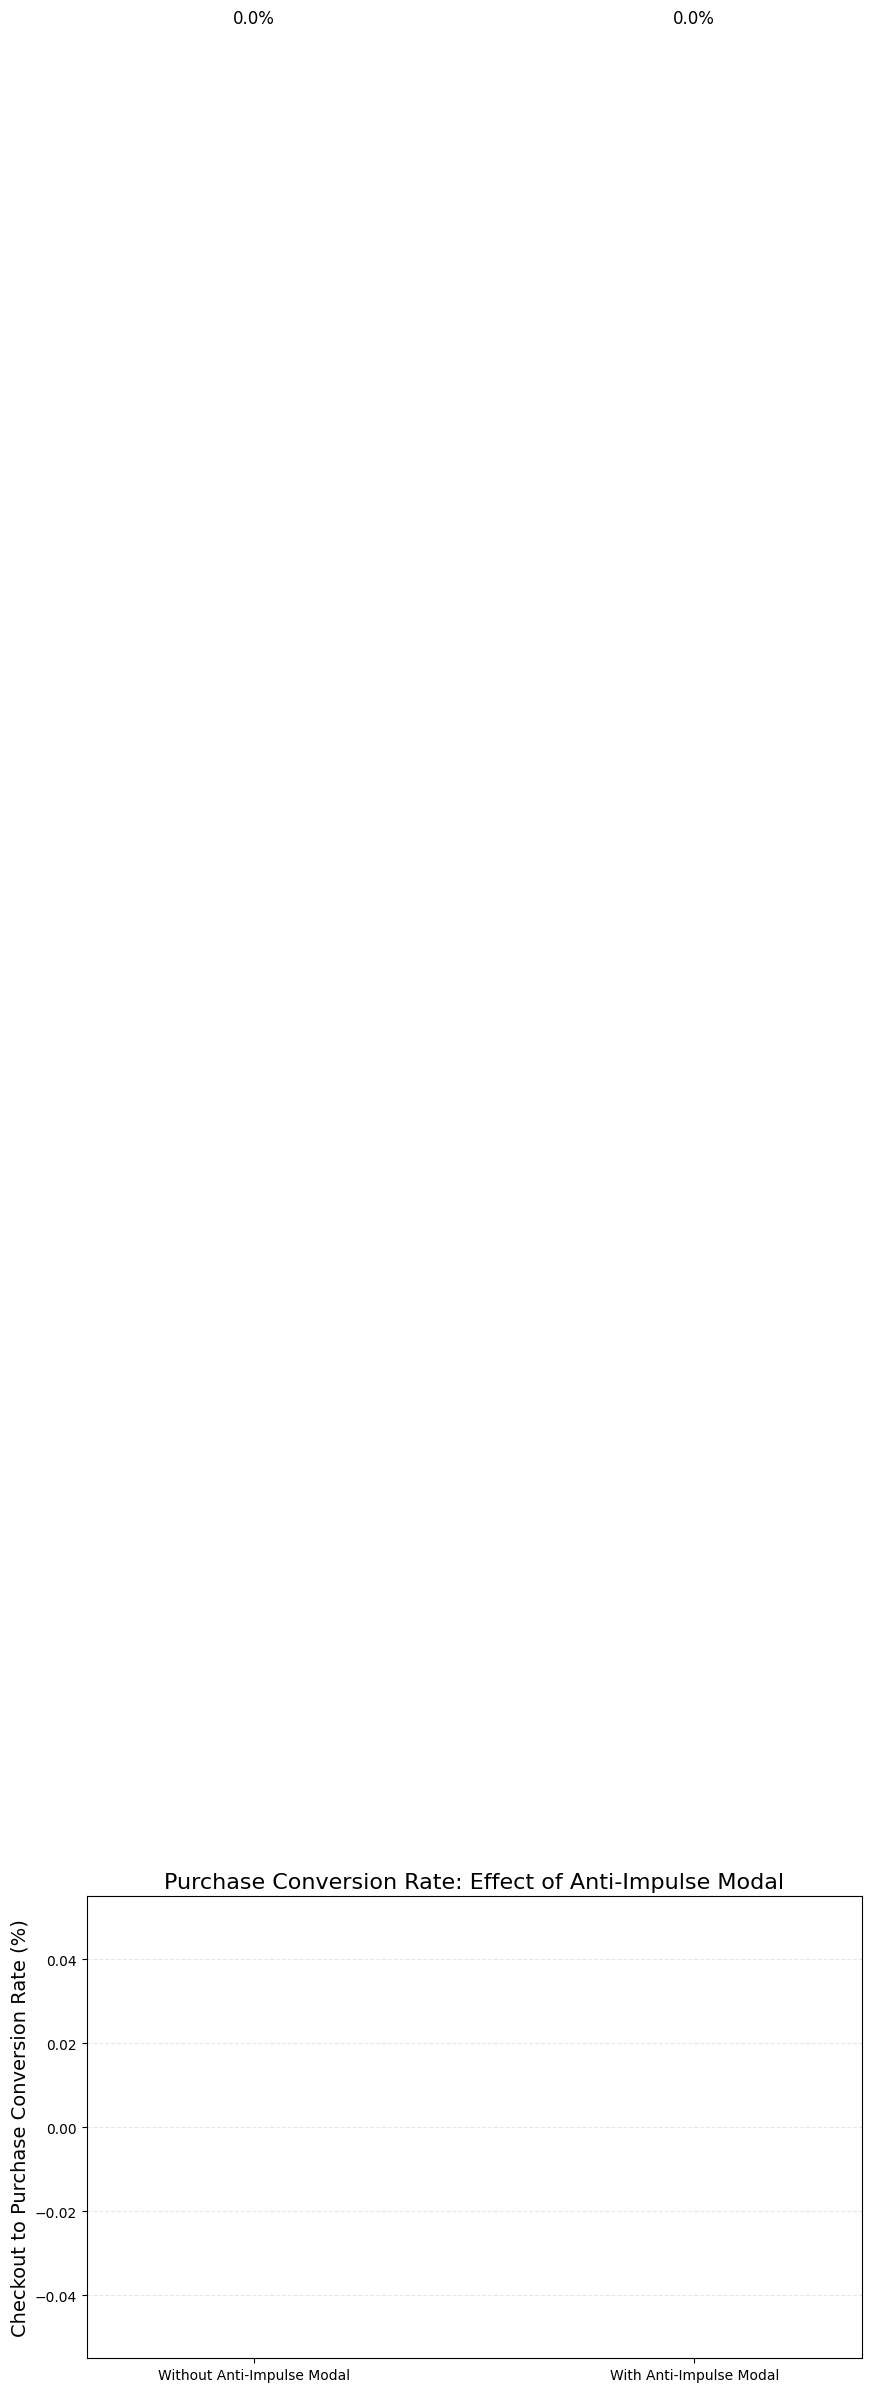

In [ ]:
# Modal Influence Analysis: Does the anti-impulse modal affect purchase behavior?

# Get sessions with checkout visits
checkout_sessions_list = checkout_df['session_id'].unique()

# Filter for sessions where modal was shown
modal_sessions_list = modal_df['session_id'].unique()

# Get sessions with purchases
purchase_sessions_list = purchase_df['session_id'].unique()

# Count conversions
with_modal_sessions = set(checkout_sessions_list).intersection(set(modal_sessions_list))
without_modal_sessions = set(checkout_sessions_list) - set(modal_sessions_list)

# Count purchases in each group
purchases_with_modal = len(set(with_modal_sessions).intersection(set(purchase_sessions_list)))
purchases_without_modal = len(set(without_modal_sessions).intersection(set(purchase_sessions_list)))

# Calculate conversion rates
modal_conversion_rate = purchases_with_modal / len(with_modal_sessions) if len(with_modal_sessions) > 0 else 0
no_modal_conversion_rate = purchases_without_modal / len(without_modal_sessions) if len(without_modal_sessions) > 0 else 0

print("\nModal Influence Analysis:")
print(f"Checkout sessions with modal shown: {len(with_modal_sessions)}")
print(f"Checkout sessions without modal: {len(without_modal_sessions)}")
print(f"Purchases from sessions with modal: {purchases_with_modal}")
print(f"Purchases from sessions without modal: {purchases_without_modal}")
print(f"Purchase conversion rate with modal: {modal_conversion_rate:.2%}")
print(f"Purchase conversion rate without modal: {no_modal_conversion_rate:.2%}")
print(f"Difference: {(modal_conversion_rate - no_modal_conversion_rate):.2%}")

# Create comparison bar chart
plt.figure(figsize=(10, 6))
conversion_data = [no_modal_conversion_rate * 100, modal_conversion_rate * 100]
labels = ['Without Anti-Impulse Modal', 'With Anti-Impulse Modal']
colors = ['#1f77b4', '#d62728']

bars = plt.bar(labels, conversion_data, color=colors, width=0.6)
plt.title('Purchase Conversion Rate: Effect of Anti-Impulse Modal', fontsize=16)
plt.ylabel('Checkout to Purchase Conversion Rate (%)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add the values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Additional analysis: Time from modal to purchase
if len(modal_df) > 0 and len(purchase_df) > 0:
    # Get sessions with both modal and purchase
    dual_sessions = set(modal_sessions_list).intersection(set(purchase_sessions_list))
    
    if len(dual_sessions) > 0:
        print(f"\nAnalyzing {len(dual_sessions)} sessions with both modal display and purchase:")
        
        # Create a dataframe to track time from modal to purchase
        modal_to_purchase_times = []
        
        for session in dual_sessions:
            # Get modal timestamp
            session_modals = modal_df[modal_df['session_id'] == session]
            first_modal_time = session_modals['created_at'].min()
            
            # Get purchase timestamp 
            session_purchases = purchase_df[purchase_df['session_id'] == session]
            purchase_time = session_purchases['created_at'].min()
            
            # Calculate time difference in seconds
            time_diff = (purchase_time - first_modal_time).total_seconds()
            
            modal_to_purchase_times.append({
                'session_id': session,
                'modal_time': first_modal_time,
                'purchase_time': purchase_time,
                'seconds_to_purchase': time_diff,
                'minutes_to_purchase': time_diff / 60
            })
        
        # Create DataFrame
        time_diff_df = pd.DataFrame(modal_to_purchase_times)
        
        # Calculate statistics
        avg_minutes = time_diff_df['minutes_to_purchase'].mean()
        median_minutes = time_diff_df['minutes_to_purchase'].median()
        
        print(f"Average time from modal to purchase: {avg_minutes:.2f} minutes")
        print(f"Median time from modal to purchase: {median_minutes:.2f} minutes")
        
        # Plot the distribution of times
        plt.figure(figsize=(12, 6))
        
        # Filter out extreme outliers for better visualization
        filtered_times = time_diff_df[time_diff_df['minutes_to_purchase'] < 60]  # Filter times > 1 hour
        
        sns.histplot(filtered_times['minutes_to_purchase'], kde=True, color='#d62728')
        plt.axvline(x=avg_minutes, color='black', linestyle='--', label=f'Mean: {avg_minutes:.2f} min')
        plt.axvline(x=median_minutes, color='green', linestyle='-.', label=f'Median: {median_minutes:.2f} min')
        
        plt.title('Time from Anti-Impulse Modal to Purchase', fontsize=16)
        plt.xlabel('Minutes', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

Shopping Journey Analysis for Top 5 Domains:


,domain,cart_sessions,checkout_sessions,modal_sessions,purchase_sessions
0,ikea.com,1,1,1,0
1,amazon.com,3,4,1,0
2,zara.com,1,1,1,0
3,walgreens.com,1,1,1,0
4,etsy.com,1,3,1,0



Conversion Rates:


,domain,cart_to_checkout,checkout_to_purchase,cart_to_purchase,modal_rate
0,ikea.com,1.000,0.0,0.0,1.000
1,amazon.com,1.333,0.0,0.0,0.250
2,zara.com,1.000,0.0,0.0,1.000
3,walgreens.com,1.000,0.0,0.0,1.000
4,etsy.com,3.000,0.0,0.0,0.333


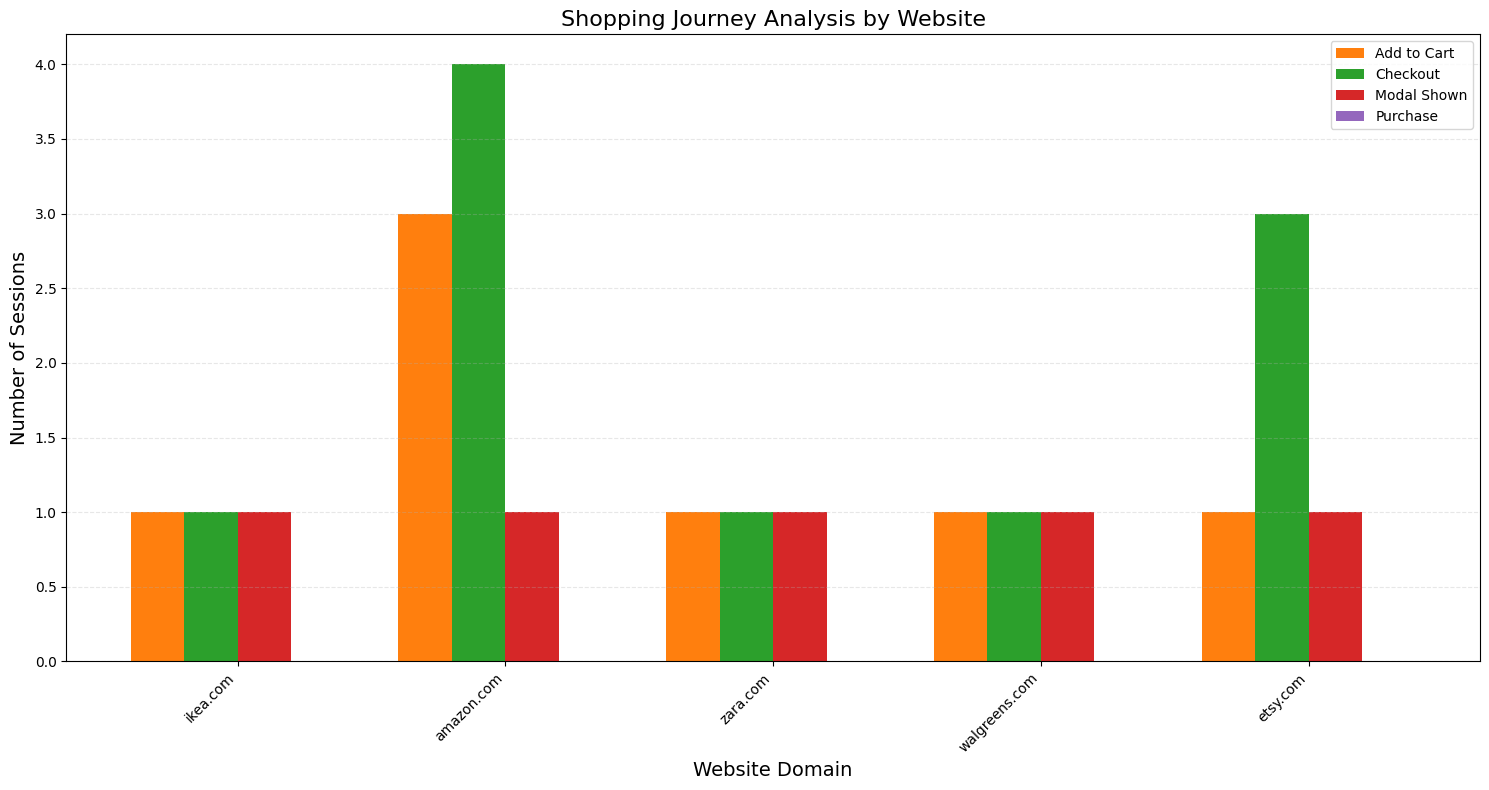

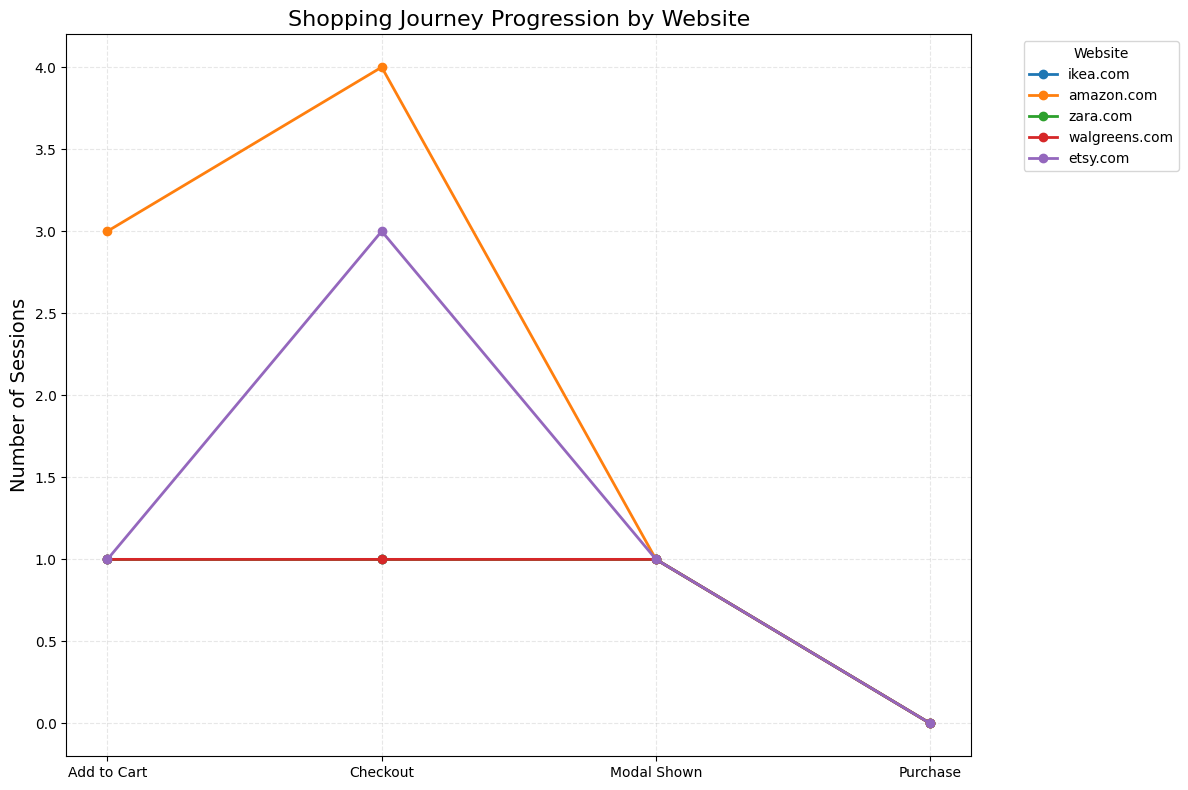

In [ ]:
# Creating a shopping journey analysis: from cart to checkout to purchase
# For each website, calculate the percentage of users who progress through each stage

# Get the top domains for this analysis
top_domains = combined_df['domain'].head(5).tolist()

# Create a function to analyze the shopping journey for a domain
def analyze_journey(domain):
    # Extract data for the specified domain
    domain_data = {}
    
    # Count add-to-cart events
    domain_cart = add_to_cart_df[add_to_cart_df['domain'] == domain]
    cart_sessions = domain_cart['session_id'].nunique()
    domain_data['cart_sessions'] = cart_sessions
    
    # Count checkout visits
    domain_checkout = checkout_df[checkout_df['domain'] == domain]
    checkout_sessions = domain_checkout['session_id'].nunique()
    domain_data['checkout_sessions'] = checkout_sessions
    
    # Count modal displays
    domain_modal = modal_df[modal_df['domain'] == domain]
    modal_sessions = domain_modal['session_id'].nunique()
    domain_data['modal_sessions'] = modal_sessions
    
    # Count purchases
    domain_purchase = purchase_df[purchase_df['domain'] == domain]
    purchase_sessions = domain_purchase['session_id'].nunique()
    domain_data['purchase_sessions'] = purchase_sessions
    
    return domain_data

# Analyze each top domain
journey_data = []
for domain in top_domains:
    domain_journey = analyze_journey(domain)
    domain_journey['domain'] = domain
    journey_data.append(domain_journey)

# Create dataframe
journey_df = pd.DataFrame(journey_data)

# Calculate conversion rates where possible
journey_df['cart_to_checkout'] = journey_df.apply(
    lambda row: row['checkout_sessions'] / row['cart_sessions'] if row['cart_sessions'] > 0 else 0, axis=1)
journey_df['checkout_to_purchase'] = journey_df.apply(
    lambda row: row['purchase_sessions'] / row['checkout_sessions'] if row['checkout_sessions'] > 0 else 0, axis=1)
journey_df['cart_to_purchase'] = journey_df.apply(
    lambda row: row['purchase_sessions'] / row['cart_sessions'] if row['cart_sessions'] > 0 else 0, axis=1)
journey_df['modal_rate'] = journey_df.apply(
    lambda row: row['modal_sessions'] / row['checkout_sessions'] if row['checkout_sessions'] > 0 else 0, axis=1)

# Display the journey dataframe
print("Shopping Journey Analysis for Top 5 Domains:")
display_journey = journey_df[['domain', 'cart_sessions', 'checkout_sessions', 'modal_sessions', 'purchase_sessions']]
display(display_journey)

# Display conversion rates
print("\nConversion Rates:")
display_rates = journey_df[['domain', 'cart_to_checkout', 'checkout_to_purchase', 'cart_to_purchase', 'modal_rate']]
display_rates = display_rates.round(3)
display(display_rates)

# Create a visualization of the shopping journey
plt.figure(figsize=(15, 8))

# Set up the bar positions
x = np.arange(len(top_domains))
width = 0.2

# Create the grouped bars
plt.bar(x - width*1.5, journey_df['cart_sessions'], width, label='Add to Cart', color='#ff7f0e')
plt.bar(x - width/2, journey_df['checkout_sessions'], width, label='Checkout', color='#2ca02c')
plt.bar(x + width/2, journey_df['modal_sessions'], width, label='Modal Shown', color='#d62728')
plt.bar(x + width*1.5, journey_df['purchase_sessions'], width, label='Purchase', color='#9467bd')

# Add labels and legend
plt.xlabel('Website Domain', fontsize=14)
plt.ylabel('Number of Sessions', fontsize=14)
plt.title('Shopping Journey Analysis by Website', fontsize=16)
plt.xticks(x, journey_df['domain'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Create an area chart showing the funnel progression
plt.figure(figsize=(12, 8))

# Create a transposed version for the area chart
journey_data_t = journey_df[['cart_sessions', 'checkout_sessions', 'modal_sessions', 'purchase_sessions']].T
journey_data_t.columns = journey_df['domain']

# Plot each domain as a separate line
for domain in journey_data_t.columns:
    plt.plot(journey_data_t.index, journey_data_t[domain], marker='o', linewidth=2, label=domain)

plt.title('Shopping Journey Progression by Website', fontsize=16)
plt.ylabel('Number of Sessions', fontsize=14)
plt.xticks(range(len(journey_data_t.index)), 
           ['Add to Cart', 'Checkout', 'Modal Shown', 'Purchase'], 
           rotation=0)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Website', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()